In [5]:
import scSherlock as sh
import scanpy as sc
import warnings
warnings.filterwarnings('ignore')

# Read HCA core lung atlas 

In [6]:
# Load the data
adata = sc.read_h5ad("/home/croizer/Downloads/lung_core_atlas.h5ad")
cell_type_column = "ann_level_1"
patient_column = "donor_id"


In [7]:
# Default features are ENSEMBL_ID, changing to gene names, take into account that gene names are gene names + _ENSG
adata.var_names = [name.split('_')[0] if '_ENSG' in name else name for name in adata.var['feature_name']]
adata.var_names_make_unique()

we need to rework a bit the hierarchy proposed by the HCA, put mesothelial cells as epithelial cells, remove the few hematopoietic stem cell identified, put the smooth muscle cells from the trachea in the smooth muscle category, and remove cell states caracterized by proliferation 

In [8]:
for col in ['ann_level_1','ann_level_2', 'ann_level_3']:
    # Convert to string
    adata.obs[col] = adata.obs[col].astype(str)
# First, identify the cells that are mesothelial cells in the finest level annotation
mesothelial_mask = adata.obs['ann_finest_level'] == 'Mesothelium'
# Now update the ann_level_3 value for these cells to "Smooth muscle"
adata.obs.loc[mesothelial_mask, 'ann_level_3'] = 'Mesothelium'
adata.obs.loc[mesothelial_mask, 'ann_level_2'] = 'Mesothelium'
adata.obs.loc[mesothelial_mask, 'ann_level_1'] = 'Epithelial'

In [9]:
# Create a mask for cells to remove (Hematopoietic stem cells)
hsc_mask = adata.obs['ann_finest_level'] == 'Hematopoietic stem cells'

# Count cells to be removed
num_to_remove = hsc_mask.sum()
print(f"Removing {num_to_remove} cells identified as 'Hematopoietic stem cells' from the dataset")

# Keep all cells EXCEPT those matching the mask
adata = adata[~hsc_mask].copy()

# Verify removal
print(f"Dataset size after removal: {adata.shape[0]} cells × {adata.shape[1]} genes")
print(f"'Hematopoietic stem cells' remaining: {(adata.obs['ann_finest_level'] == 'Hematopoietic stem cells').sum()}")

Removing 60 cells identified as 'Hematopoietic stem cells' from the dataset
Dataset size after removal: 584884 cells × 27957 genes
'Hematopoietic stem cells' remaining: 0


In [10]:
SMA_mask = adata.obs['ann_finest_level'] == 'Smooth muscle'
# Now update the ann_level_3 value for these cells to "Smooth muscle"
adata.obs.loc[SMA_mask, 'ann_level_3'] = 'Smooth muscle'


In [11]:

at0_mask = adata.obs['ann_finest_level'] == 'AT0'
# Now update the ann_level_3 value for these cells to "Smooth muscle"
adata.obs.loc[at0_mask, 'ann_level_3'] = 'AT0'
adata.obs.loc[at0_mask, 'ann_level_2'] = 'Alveolar epithelium'

In [12]:
cell_type_mapping = {
    'Suprabasal': 'Basal',
    'Basal resting': 'Basal',
    'Goblet (nasal)': 'Goblet',
    'Goblet (bronchial)': 'Goblet',
    'Goblet (subsegmental)': 'Goblet',
    'Club (non-nasal)': 'Club',
    'Club (nasal)': 'Club',
    'Multiciliated (non-nasal)': 'Multiciliated',
    'Multiciliated (nasal)': 'Multiciliated',
    'SMG serous (nasal)': 'SMG serous',
    'SMG serous (bronchial)': 'SMG serous'
}

# Add a new column with the broad cell type categories
adata.obs['curated_finest'] = adata.obs['ann_finest_level'].map(cell_type_mapping)
# For any categories not in the mapping, keep the original value (optional)
adata.obs['curated_finest'] = adata.obs['curated_finest'].fillna(adata.obs['ann_finest_level'])

In [13]:
# Define the cell types to remove
to_remove = ["T cells proliferating", "Lymphatic EC proliferating", 'AT2 proliferating', 'Alveolar Mph proliferating']

# Create a mask for cells to remove (multiple types)
prolif_mask = adata.obs['ann_finest_level'].isin(to_remove)

# Count cells to be removed
num_to_remove = prolif_mask.sum()
print(f"Removing {num_to_remove} cells identified as {to_remove} from the dataset")

# Keep all cells EXCEPT those matching the mask
adata = adata[~prolif_mask].copy()


Removing 2565 cells identified as ['T cells proliferating', 'Lymphatic EC proliferating', 'AT2 proliferating', 'Alveolar Mph proliferating'] from the dataset


In [14]:
for col in ['ann_level_1','ann_level_2', 'ann_level_3', "ann_finest_level"]:
    adata.obs[col] = adata.obs[col].astype('category')

## Create sCherlock object removing the biggest dataset from the cohort

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split

# Get unique cell annotations
cell_types = adata.obs['curated_finest'].unique()

# Initialize index lists
train_indices, test_indices = [], []

# Split each cell type with the same ratio
for cell_type in cell_types:
    cell_indices = np.where(adata.obs['curated_finest'] == cell_type)[0]
    ct_train_idx, ct_test_idx = train_test_split(cell_indices, test_size=0.5, random_state=42)
    train_indices.extend(ct_train_idx)
    test_indices.extend(ct_test_idx)

# Create the split AnnData objects
adata_train = adata[train_indices].copy()
adata_test = adata[test_indices].copy()

# Add split information
adata_train.obs['split'] = 'train'
adata_test.obs['split'] = 'test'

# Print statistics
print(f"Split: {len(adata_train)} training cells, {len(adata_test)} test cells")

Split: 291145 training cells, 291174 test cells


In [14]:
# Create configuration
config = sh.ScSherlockConfig(
    k_values=[1, 10, 25],
    scoring_method=sh.ScoringMethod.DIFF,
    aggregation_method=sh.AggregationMethod.MEAN,
    max_genes_kept=100,
    min_patients=3,
    min_reads=10,
    sparse_step=5,
    n_jobs=-1
)

# Initialize SCherlock
scherlock = sh.ScSherlock(
    adata=adata_train,
    column_patient=patient_column,
    config=config
)

2025-04-25 10:13:12,112 - ScSherlock - INFO - ScSherlock initialized with (291145, 27957) data matrix


### Run for last annotation level

In [15]:
cell_type_column = "curated_finest"
# Run analysis across datasets
scherlock.run_dataset(
    column_ctype=cell_type_column,     # Cell type annotations
    column_dataset='dataset',   # Dataset column
    min_shared=2,                 # Require markers to be shared in at least 2 datasets
    method="empiric"              # Use empirical scoring method
)


2025-04-25 10:13:12,123 - ScSherlock - INFO - Found 14 datasets: Krasnow_2020, Lafyatis_Rojas_2019_10Xv2, Misharin_Budinger_2018, Misharin_2021, Banovich_Kropski_2020, Teichmann_Meyer_2019, Barbry_Leroy_2020, Meyer_2019, Lafyatis_Rojas_2019_10Xv1, Nawijn_2021, Jain_Misharin_2021_10Xv2, Jain_Misharin_2021_10Xv1, Seibold_2020_10Xv3, Seibold_2020_10Xv2
2025-04-25 10:13:12,133 - ScSherlock - INFO - Found 50 cell types in the combined data
2025-04-25 10:13:12,133 - ScSherlock - INFO - Processing dataset: Krasnow_2020
2025-04-25 10:13:12,616 - ScSherlock - INFO - Dataset Krasnow_2020 has 48 cell types
2025-04-25 10:13:12,619 - ScSherlock - INFO - ScSherlock initialized with (30438, 27957) data matrix
2025-04-25 10:13:12,648 - ScSherlock - WARNING - Cell type 'Goblet' has fewer than 10 cells
2025-04-25 10:13:12,677 - ScSherlock - WARNING - Cell type 'Neuroendocrine' has fewer than 10 cells
2025-04-25 10:13:12,680 - ScSherlock - WARNING - Cell type 'Lymphatic EC differentiating' has fewer than

{'Alveolar macrophages': {'ZNF788P': ['Krasnow_2020', 'Banovich_Kropski_2020'],
  'ENSG00000236341.1': ['Krasnow_2020', 'Lafyatis_Rojas_2019_10Xv2'],
  'LINC01645': ['Krasnow_2020',
   'Lafyatis_Rojas_2019_10Xv2',
   'Banovich_Kropski_2020'],
  'PDE1B': ['Krasnow_2020', 'Barbry_Leroy_2020'],
  'LENG9': ['Misharin_Budinger_2018', 'Banovich_Kropski_2020'],
  'DNASE2B': ['Lafyatis_Rojas_2019_10Xv2',
   'Banovich_Kropski_2020',
   'Teichmann_Meyer_2019',
   'Meyer_2019'],
  'ESR1': ['Banovich_Kropski_2020', 'Barbry_Leroy_2020'],
  'ENSG00000258603.5': ['Krasnow_2020',
   'Misharin_Budinger_2018',
   'Banovich_Kropski_2020',
   'Barbry_Leroy_2020',
   'Meyer_2019'],
  'BRSK1': ['Barbry_Leroy_2020', 'Meyer_2019'],
  'HOXB7': ['Misharin_Budinger_2018', 'Barbry_Leroy_2020'],
  'SIGLEC11': ['Krasnow_2020', 'Misharin_Budinger_2018', 'Meyer_2019'],
  'ENSG00000272555.1': ['Krasnow_2020', 'Banovich_Kropski_2020'],
  'ADORA1': ['Krasnow_2020',
   'Banovich_Kropski_2020',
   'Barbry_Leroy_2020',
   

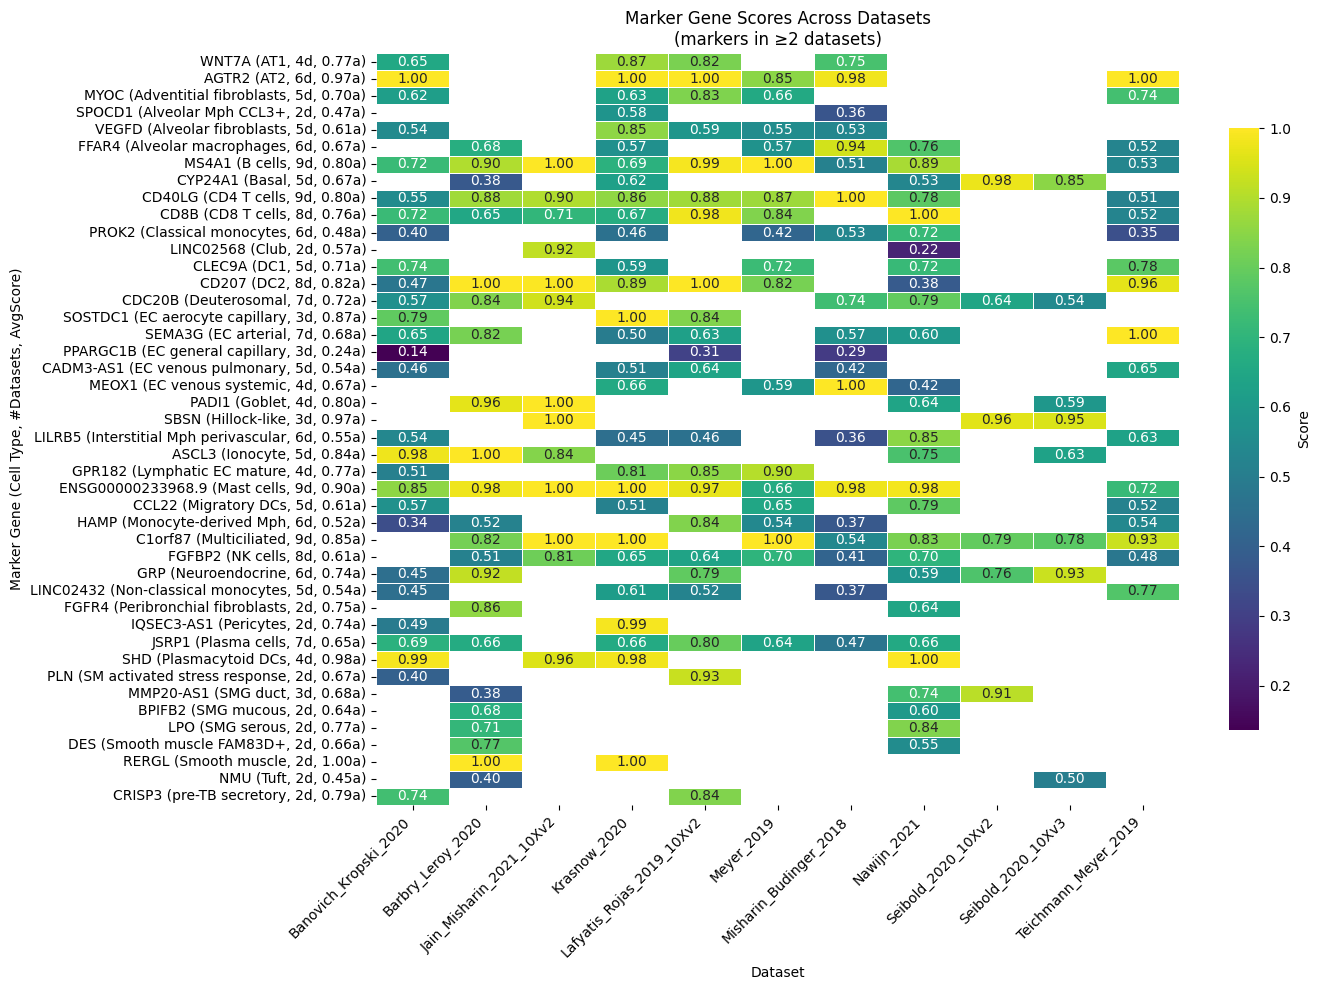

In [16]:
scherlock.plot_dataset_heatmap( 'curated_finest'
, 'dataset', display_score=True, n_top_markers=1, min_datasets=2)


In [17]:
for col in scherlock.adata.obs.columns:
    scherlock.adata.obs[col] = scherlock.adata.obs[col].astype('category')

2025-04-25 10:26:08,952 - ScSherlock - INFO - Using dataset analysis results with weighted_score
2025-04-25 10:26:08,994 - ScSherlock - INFO - Plotting 44 genes for 50 cell types using dataset analysis with weighted_score


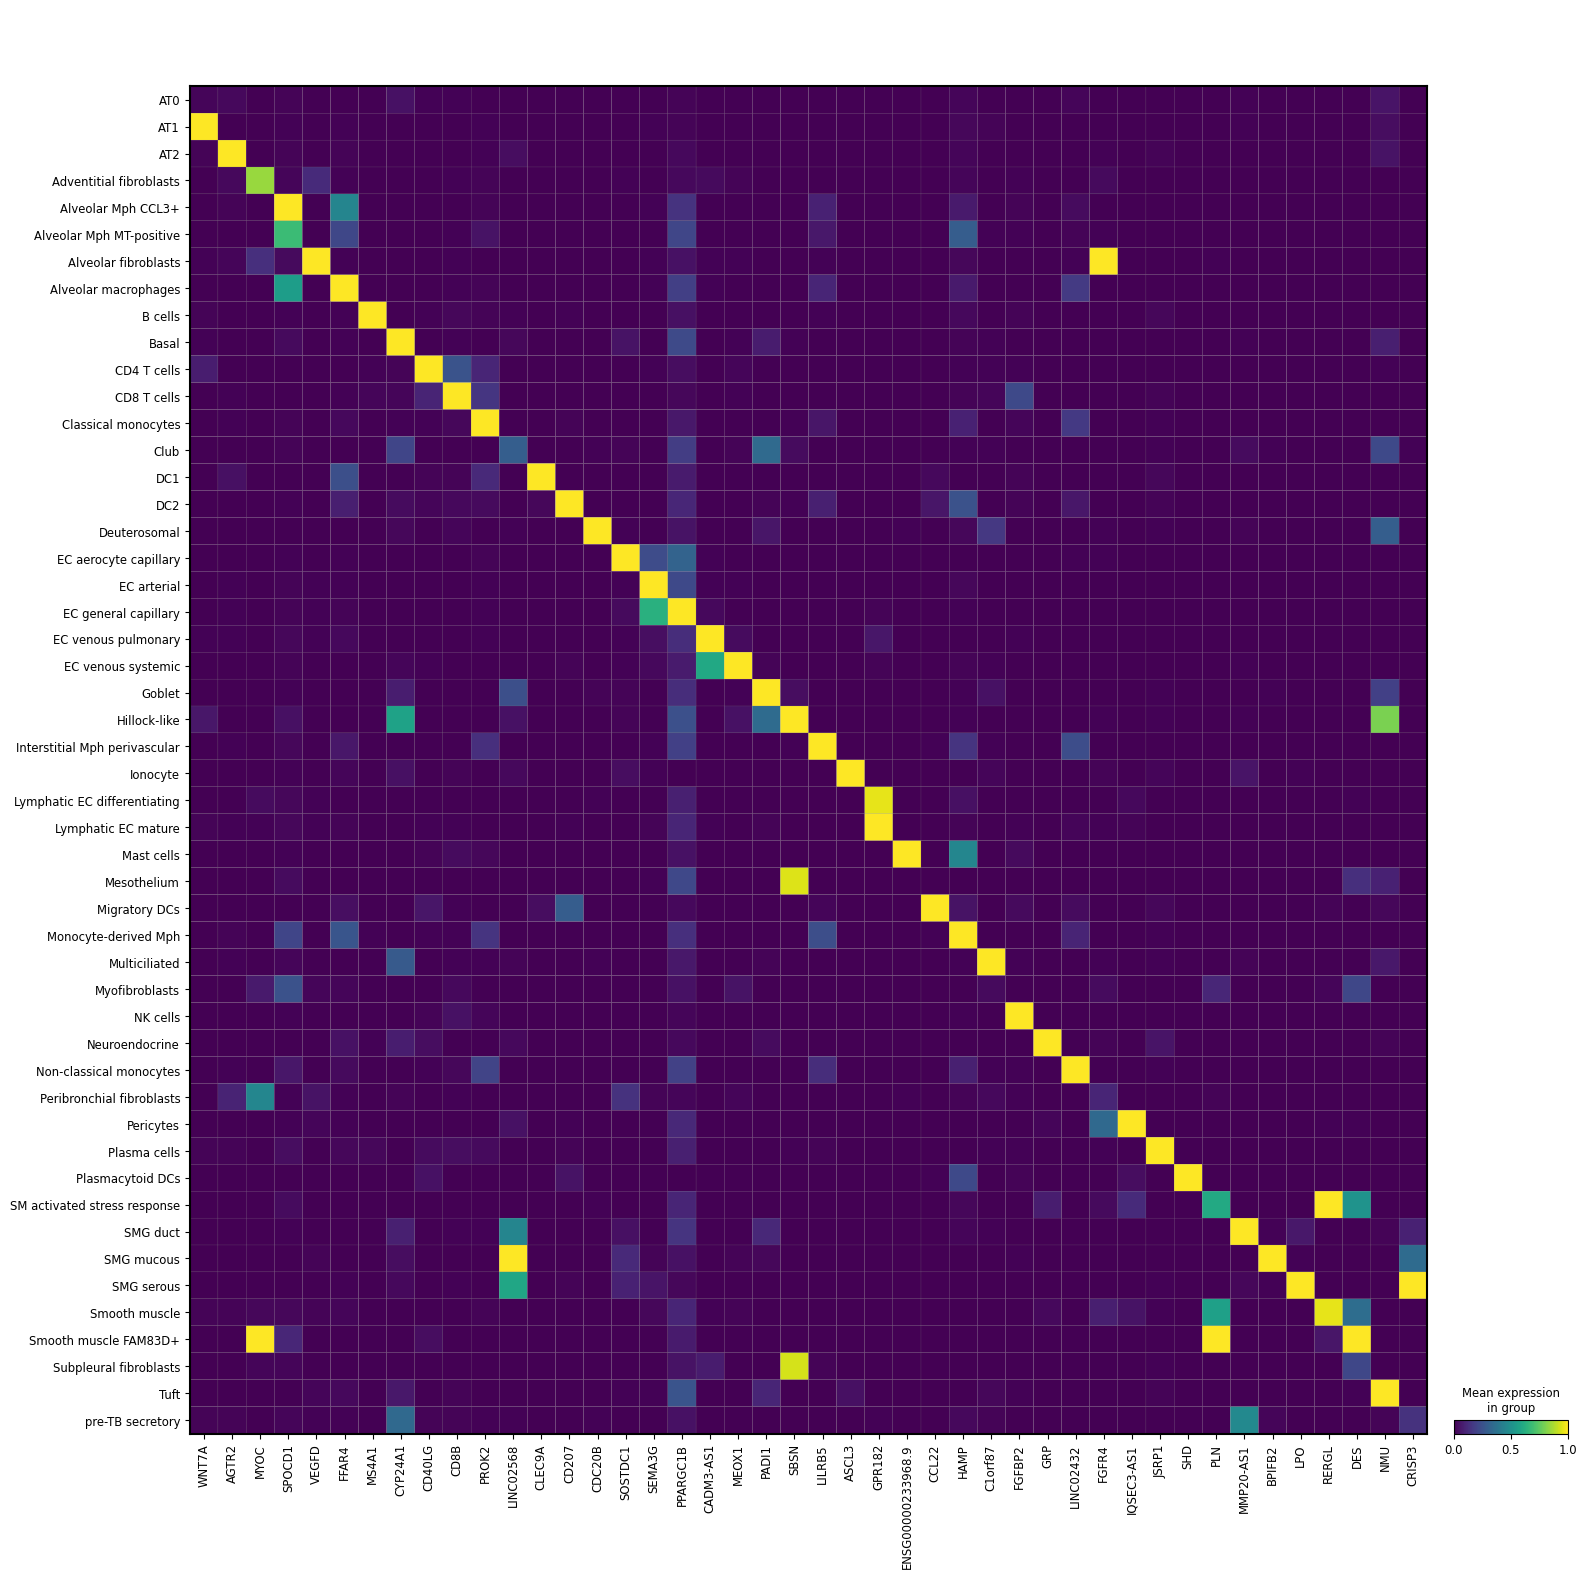

In [18]:
scherlock.plot_marker_heatmap(n_genes=1, column_ctype='curated_finest',  cutoff=0, remove_ctype_no_marker=False, dataset_column="dataset")

In [19]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Union, Optional, Callable
from scipy.stats import binom, percentileofscore
from adpbulk import ADPBulk
import logging
from dataclasses import dataclass
from enum import Enum
from joblib import Parallel, delayed
import scipy
import numba as nb
from sklearn.preprocessing import StandardScaler
from statsmodels.distributions.empirical_distribution import ECDF
import gc
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from collections import defaultdict

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger('ScSherlock')

def get_marker(self, column_ctype: str, method: str = "empiric", dataset_column: str = None, 
             score_type: str = "aggregated", n_top_genes: int = 1, min_score: float = 0.0) -> pd.DataFrame:
    """
    Get marker genes and their scores for specified cell types.
    
    Args:
        column_ctype: Column name in adata.obs for cell type annotations
        method: Method to use, either "theoric" or "empiric" (default: "empiric")
        dataset_column: If provided, use markers from dataset analysis using this column (default: None)
        score_type: Which score to use (default: "aggregated")
            For regular analysis: "aggregated" or any column in the sorted tables
            For dataset analysis: "avg_score", "weighted_score", or "num_datasets"
        n_top_genes: Number of top genes to return for each cell type (default: 1)
        min_score: Minimum score threshold for including markers (default: 0.0)
            
    Returns:
        pd.DataFrame: DataFrame with marker genes and their scores
        
    Raises:
        ValueError: If specified method or dataset_column is not valid
    """
    # Validate method parameter
    if method not in ["theoric", "empiric"]:
        raise ValueError('Method must be either "theoric" or "empiric"')
    
    # Check if we're using dataset analysis
    using_dataset_analysis = False
    if dataset_column is not None:
        dataset_key = f"{column_ctype}_by_{dataset_column}"
        if dataset_key in self.__dict__ and 'combined_tables' in self.__dict__[dataset_key]:
            using_dataset_analysis = True
            
            # Validate score_type for dataset analysis
            valid_score_types = ["avg_score", "weighted_score", "num_datasets"]
            if score_type not in valid_score_types:
                logger.warning(f"Invalid score_type '{score_type}' for dataset analysis. Using 'weighted_score' instead.")
                score_type = "weighted_score"
        else:
            raise ValueError(f"Dataset analysis for {column_ctype} by {dataset_column} not found. Run run_dataset() first.")
    
    # Check if the annotation has been processed
    if not using_dataset_analysis:
        if column_ctype not in self.method_run:
            raise ValueError(f"No analysis exists for {column_ctype}. Run ScSherlock.run() with this annotation first.")
            
        # Check if the requested method has been run
        if method == "empiric" and (column_ctype not in self.sorted_empirical_table or self.sorted_empirical_table[column_ctype] is None):
            raise ValueError(f"Empirical scores haven't been calculated for {column_ctype}. Run with method='empiric' first.")
            
        if method == "theoric" and (column_ctype not in self.sorted_table or self.sorted_table[column_ctype] is None):
            raise ValueError(f"Theoretical scores haven't been calculated for {column_ctype}. Run with method='theoric' first.")
    
    # Prepare results DataFrame
    results = []
    
    # Get markers based on dataset analysis or regular analysis
    if using_dataset_analysis:
        # Get combined tables from dataset analysis
        combined_tables = self.__dict__[dataset_key]['combined_tables']
        
        # Process each cell type
        for cell_type, table in combined_tables.items():
            if table.empty:
                continue
                
            # Filter by minimum score
            if score_type in table.columns:
                filtered_table = table[table[score_type] >= min_score]
            else:
                logger.warning(f"Score type '{score_type}' not found in table for {cell_type}. Using all markers.")
                filtered_table = table
                
            # Skip if no markers remain
            if filtered_table.empty:
                continue
                
            # Sort by specified score type if it exists
            if score_type in filtered_table.columns:
                filtered_table = filtered_table.sort_values(score_type, ascending=False)
                
            # Get top N genes
            top_genes = filtered_table.head(n_top_genes)
            
            # Add to results
            for marker, row in top_genes.iterrows():
                # Get scores for all available columns
                marker_data = {
                    'cell_type': cell_type,
                    'marker_gene': marker,
                }
                
                # Add all available scores
                for col in row.index:
                    if col.startswith('score_') or col in ['avg_score', 'weighted_score', 'num_datasets']:
                        marker_data[col] = row[col]
                
                # Add datasets list if available
                if 'datasets' in row:
                    marker_data['datasets'] = row['datasets']
                    
                results.append(marker_data)
    else:
        # Get appropriate tables based on the method
        if method == "empiric":
            sorted_tables = self.sorted_empirical_table[column_ctype]
        else:  # method == "theoric"
            sorted_tables = self.sorted_table[column_ctype]
            
        # Process each cell type
        for cell_type, table in sorted_tables.items():
            if not isinstance(table, pd.DataFrame) or table.empty:
                continue
                
            # Validate score_type for regular analysis
            if score_type not in table.columns:
                if score_type != "aggregated":
                    logger.warning(f"Score type '{score_type}' not found in table for {cell_type}. Using 'aggregated' instead.")
                score_type = "aggregated"
                
            # Filter by minimum score
            filtered_table = table[table[score_type] >= min_score]
            
            # Skip if no markers remain
            if filtered_table.empty:
                continue
                
            # Sort by score type
            filtered_table = filtered_table.sort_values(score_type, ascending=False)
            
            # Get top N genes
            top_genes = filtered_table.head(n_top_genes)
            
            # Add to results
            for marker, row in top_genes.iterrows():
                # Get basic data
                marker_data = {
                    'cell_type': cell_type,
                    'marker_gene': marker,
                    'score': row[score_type]
                }
                
                # Add method used
                marker_data['method'] = method
                
                # Add expression proportion if available
                if 'exp_prop' in row:
                    marker_data['expression_proportion'] = row['exp_prop']
                    
                # Add bootstrap results if available
                if 'bootstrap_pass' in row:
                    marker_data['bootstrap_pass'] = row['bootstrap_pass']
                    
                if 'bootstrap_1_score' in row:
                    marker_data['bootstrap_1_score'] = row['bootstrap_1_score']
                    
                if 'bootstrap_2_score' in row:
                    marker_data['bootstrap_2_score'] = row['bootstrap_2_score']
                    
                results.append(marker_data)
    
    # If no results found, return empty DataFrame with appropriate columns
    if not results:
        if using_dataset_analysis:
            columns = ['cell_type', 'marker_gene', 'avg_score', 'weighted_score', 'num_datasets']
        else:
            columns = ['cell_type', 'marker_gene', 'score', 'method']
        return pd.DataFrame(columns=columns)
    
    # Convert to DataFrame
    markers_df = pd.DataFrame(results)
    
    # Sort by cell type
    markers_df = markers_df.sort_values('cell_type')
    
    return markers_df

markers = get_marker(scherlock, column_ctype='curated_finest', method="empiric", dataset_column="dataset", score_type="weighted_scores", n_top_genes=1, min_score=0.0)
markers

2025-04-25 10:26:10,074 - ScSherlock - WARNING - Invalid score_type 'weighted_scores' for dataset analysis. Using 'weighted_score' instead.


,cell_type,marker_gene,score_Krasnow_2020,score_Lafyatis_Rojas_2019_10Xv2,score_Misharin_Budinger_2018,score_Misharin_2021,score_Banovich_Kropski_2020,score_Teichmann_Meyer_2019,score_Barbry_Leroy_2020,score_Meyer_2019,score_Lafyatis_Rojas_2019_10Xv1,score_Nawijn_2021,score_Jain_Misharin_2021_10Xv2,score_Jain_Misharin_2021_10Xv1,score_Seibold_2020_10Xv3,score_Seibold_2020_10Xv2,avg_score,num_datasets,weighted_score,datasets
10,AT1,WNT7A,0.873446,0.824884,0.747650,NaN,0.652864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.774711,4,0.221346,"Krasnow_2020, Lafyatis_Rojas_2019_10Xv2, Misha..."
2,AT2,AGTR2,0.996212,1.000000,0.981735,NaN,1.000000,1.000000,NaN,0.850639,NaN,NaN,NaN,NaN,NaN,NaN,0.971431,6,0.416328,"Krasnow_2020, Lafyatis_Rojas_2019_10Xv2, Misha..."
23,Adventitial fibroblasts,MYOC,0.632903,0.833654,NaN,NaN,0.616494,0.743518,NaN,0.656998,NaN,NaN,NaN,NaN,NaN,NaN,0.696713,5,0.248826,"Krasnow_2020, Lafyatis_Rojas_2019_10Xv2, Banov..."
3,Alveolar Mph CCL3+,SPOCD1,0.583185,NaN,0.363641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.473413,2,0.067630,"Krasnow_2020, Misharin_Budinger_2018"
28,Alveolar fibroblasts,VEGFD,0.854141,0.589571,0.532622,NaN,0.544909,NaN,NaN,0.553404,NaN,NaN,NaN,NaN,NaN,NaN,0.614929,5,0.219618,"Krasnow_2020, Lafyatis_Rojas_2019_10Xv2, Misha..."
0,Alveolar macrophages,FFAR4,0.566733,NaN,0.941818,NaN,NaN,0.524778,0.676933,0.573749,NaN,0.763762,NaN,NaN,NaN,NaN,0.674629,6,0.289127,"Krasnow_2020, Misharin_Budinger_2018, Teichman..."
32,B cells,MS4A1,0.689292,0.986561,0.514172,NaN,0.721695,0.532309,0.898635,0.998012,NaN,0.887572,1.000000,NaN,NaN,NaN,0.803138,9,0.516303,"Krasnow_2020, Lafyatis_Rojas_2019_10Xv2, Misha..."
4,Basal,CYP24A1,0.622396,NaN,NaN,NaN,NaN,NaN,0.376110,NaN,NaN,0.533577,NaN,NaN,0.849151,0.975609,0.671369,5,0.239775,"Krasnow_2020, Barbry_Leroy_2020, Nawijn_2021, ..."
9,CD4 T cells,CD40LG,0.857531,0.876981,1.000000,NaN,0.551029,0.513567,0.878495,0.874312,NaN,0.781608,0.898774,NaN,NaN,NaN,0.803589,9,0.516593,"Krasnow_2020, Lafyatis_Rojas_2019_10Xv2, Misha..."
6,CD8 T cells,CD8B,0.674496,0.981805,NaN,NaN,0.723117,0.524968,0.649911,0.835364,NaN,0.998201,0.705561,NaN,NaN,NaN,0.761678,8,0.435245,"Krasnow_2020, Lafyatis_Rojas_2019_10Xv2, Banov..."


In [20]:
adata_test.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 566655945 stored elements and shape (291174, 27957)>

... storing 'curated_finest' as categorical
... storing 'split' as categorical


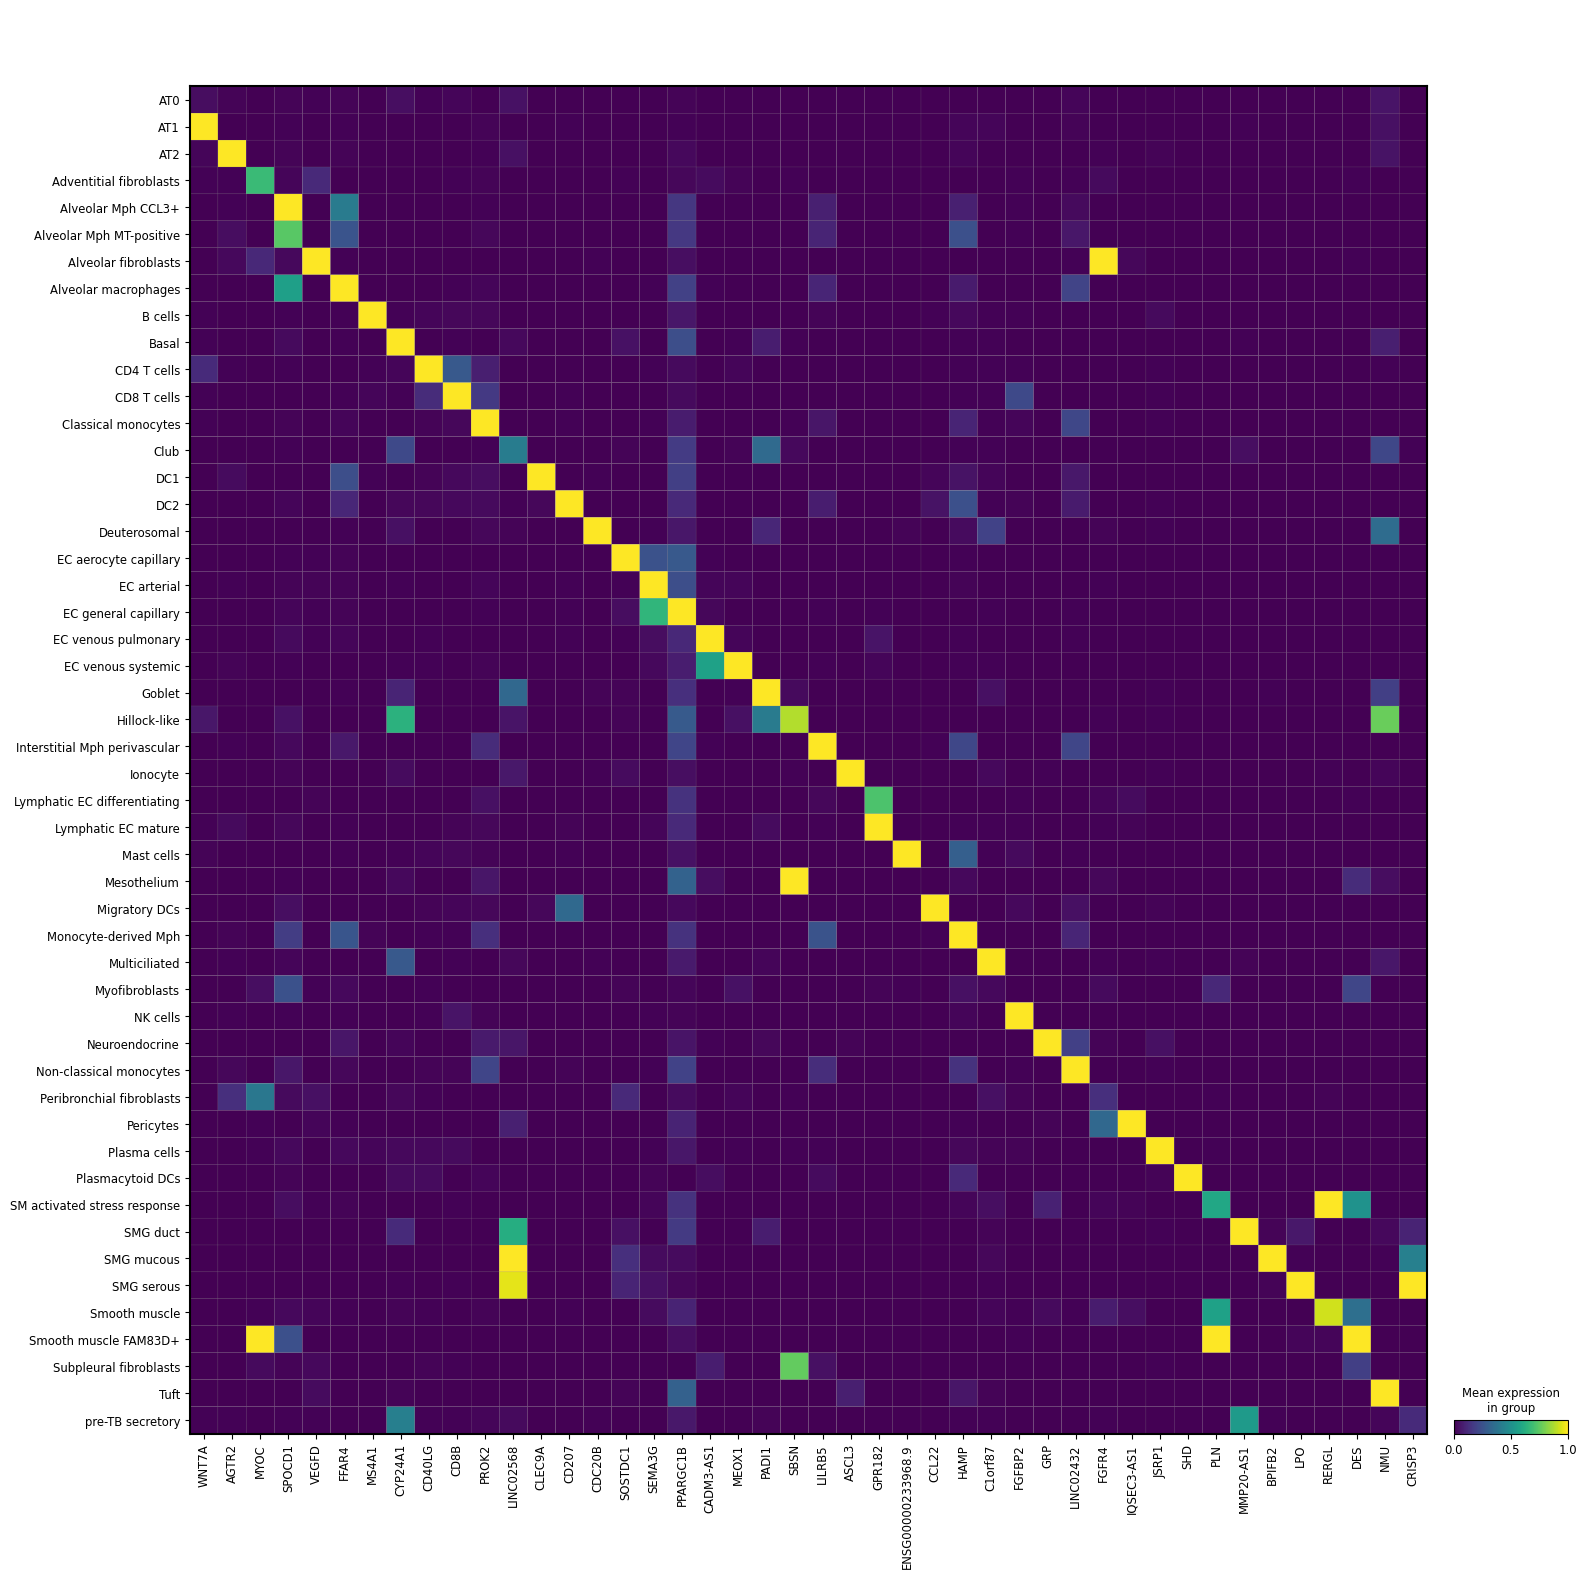

In [21]:
sc.pl.matrixplot(adata_test, groupby='curated_finest', var_names=markers['marker_gene'], use_raw=False, cmap='viridis', standard_scale='var')

... storing 'curated_finest' as categorical


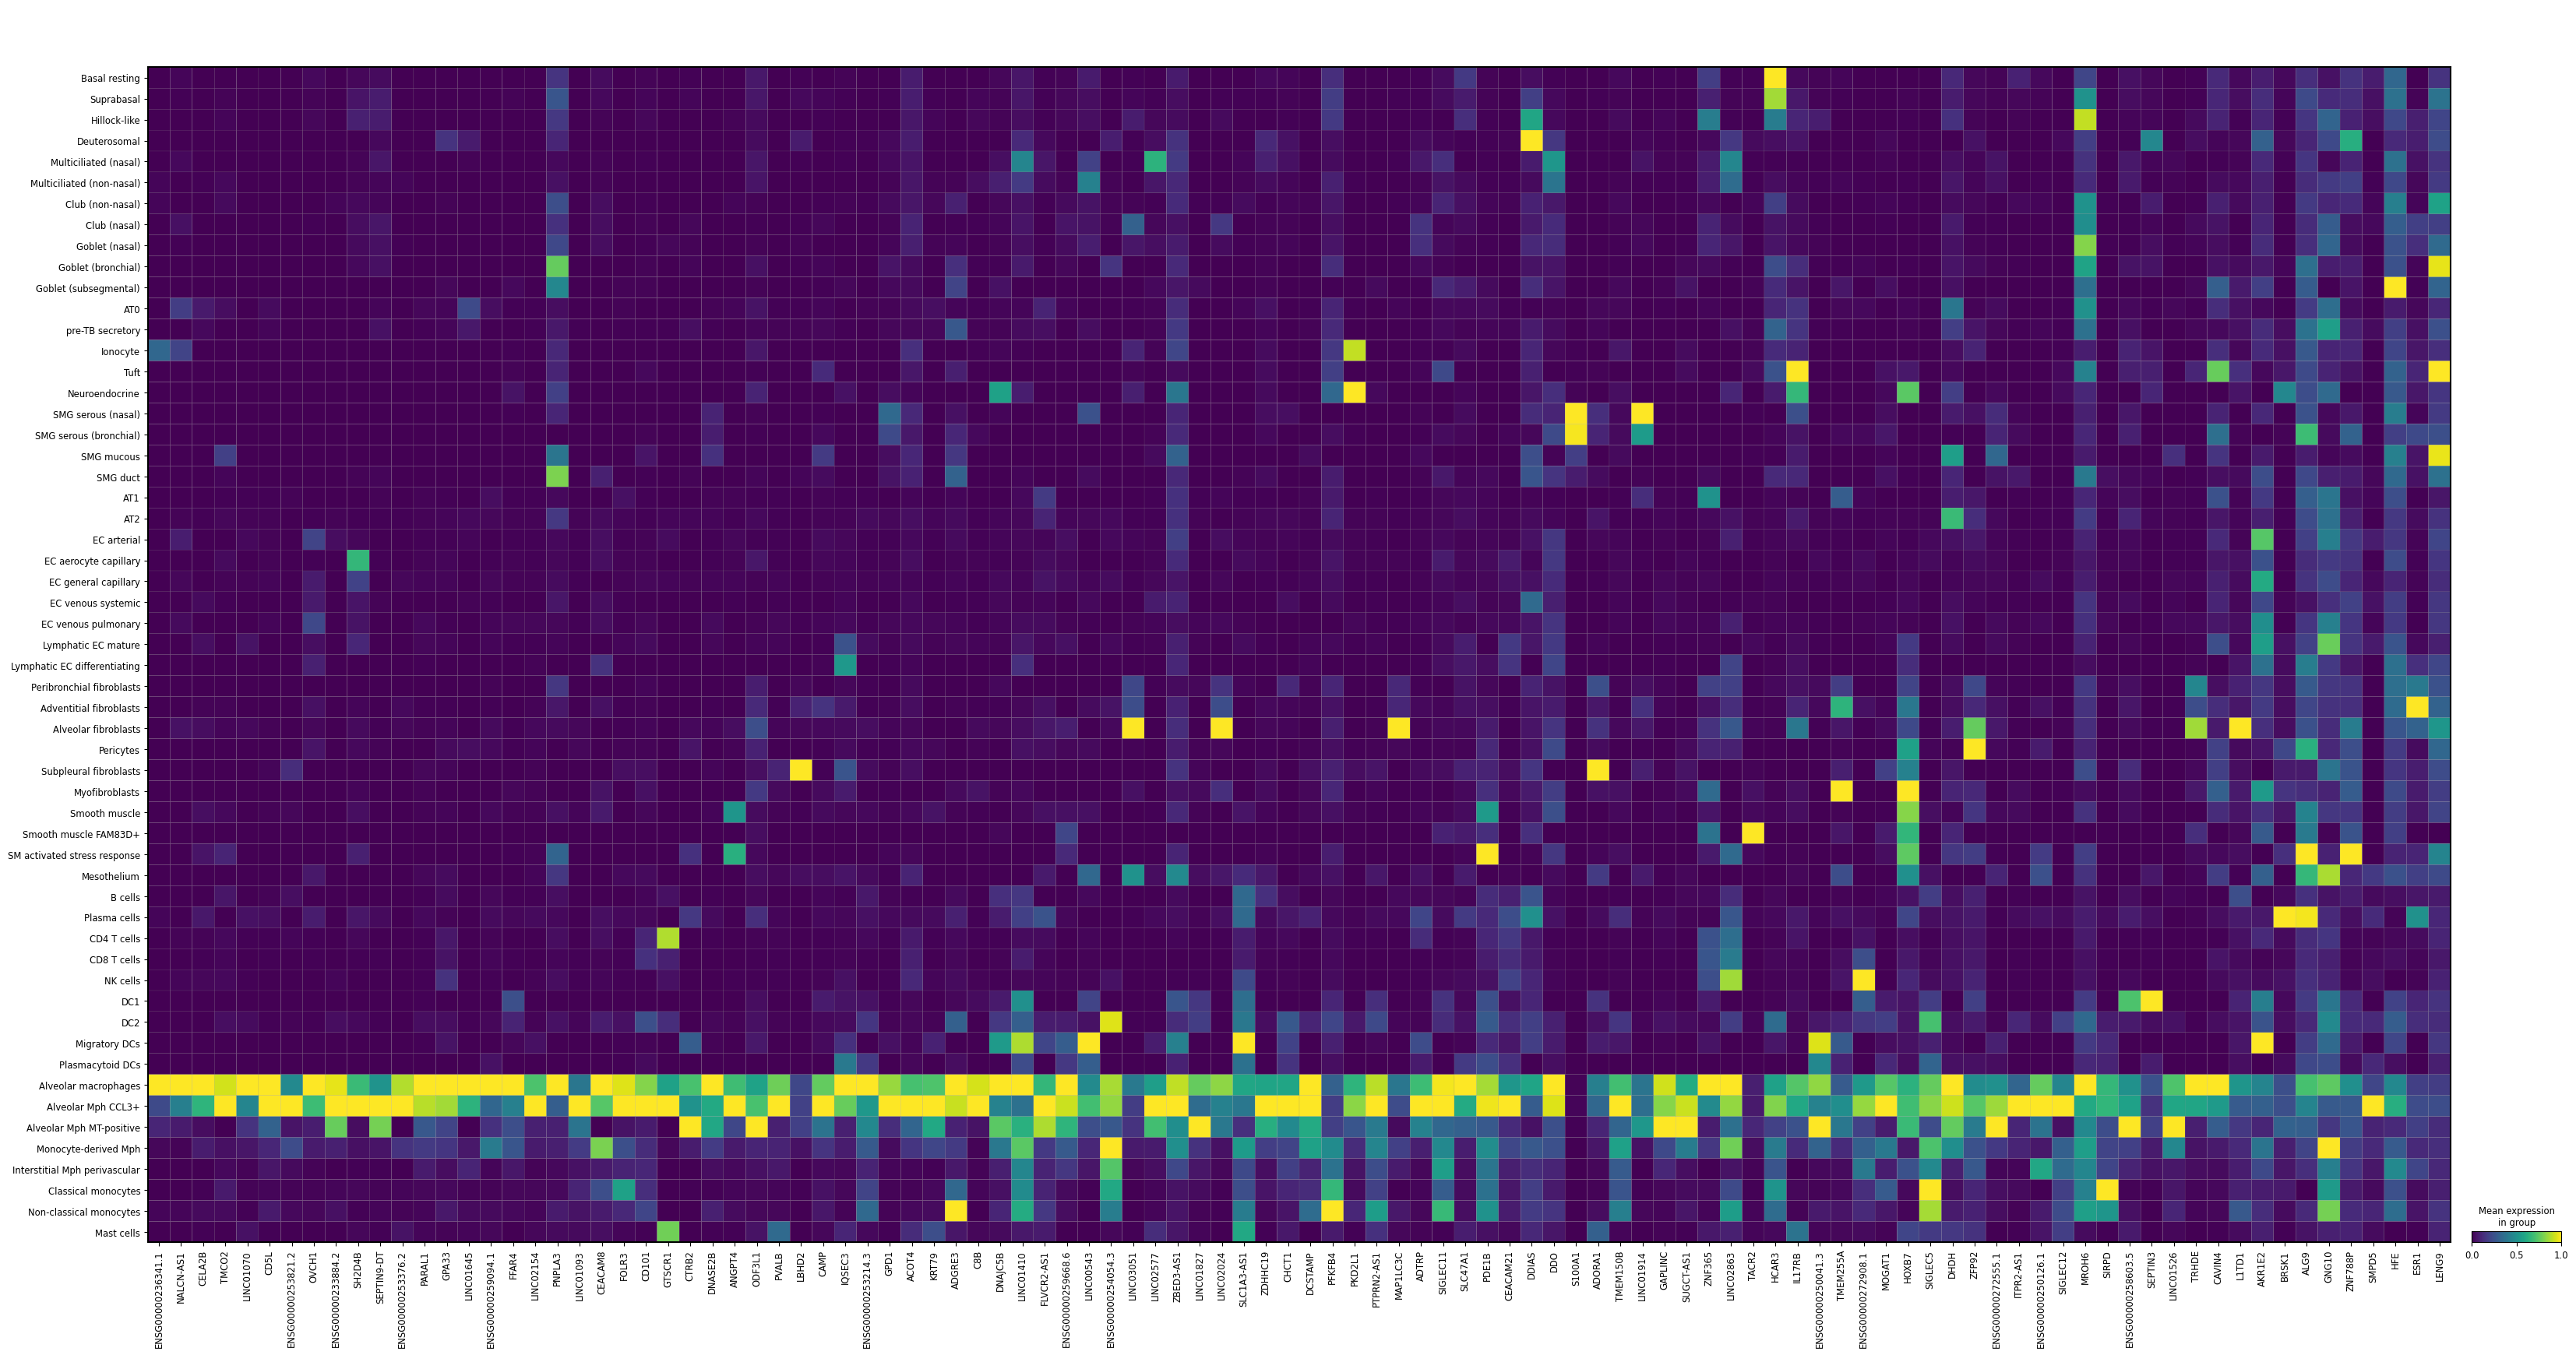

In [22]:
sc.pl.matrixplot(adata, scherlock.sorted_empirical_table['curated_finest']['Alveolar macrophages'].index, groupby='ann_finest_level',  standard_scale='var', use_raw=False, swap_axes=False)

In [23]:
fig = scherlock.visualize_hierarchy_marker(cutoff=0)

2025-04-25 10:26:15,190 - ScSherlock - INFO - Found empirical marker scores for curated_finest


ValueError: No hierarchical graph present in ScSherlock object. Call create_hierarchy_graph first.

In [ ]:
scherlock.run(column_ctype="cell_type", method='empiric', bootstrap=False)

2025-04-24 13:35:02,497 - ScSherlock - INFO - Calculating theoretical scores for cell_type...
Aggregating Samples: 100%|██████████| 5136/5136 [00:02<00:00, 2119.11it/s]
2025-04-24 13:35:40,919 - ScSherlock - INFO - Completed theoretical score calculation
2025-04-24 13:35:40,920 - ScSherlock - INFO - Applying multi-category correction...
2025-04-24 13:35:41,033 - ScSherlock - INFO - Aggregating scores...
2025-04-24 13:35:41,147 - ScSherlock - INFO - Sorting scores...
2025-04-24 13:35:41,287 - ScSherlock - INFO - Filtering genes...
Aggregating Samples: 100%|██████████| 48/48 [00:02<00:00, 18.27it/s]
2025-04-24 13:35:48,054 - ScSherlock - INFO - Calculating empirical scores...
2025-04-24 13:37:58,619 - ScSherlock - INFO - Aggregating empirical scores...
2025-04-24 13:37:58,627 - ScSherlock - INFO - Sorting empirical scores...
2025-04-24 13:37:58,659 - ScSherlock - INFO - Identifying top markers...
2025-04-24 13:37:58,661 - ScSherlock - INFO - ScSherlock completed. Found markers for 39/48 

{'alveolar macrophage': 'LINC02154',
 'natural killer cell': 'LIM2',
 'pulmonary alveolar type 2 cell': 'CPB2',
 'respiratory basal cell': 'CYP2W1',
 'vein endothelial cell': 'SELE',
 'CD8-positive, alpha-beta T cell': 'TRGV2',
 'pulmonary artery endothelial cell': 'ENSG00000233760.3',
 'CD4-positive, alpha-beta T cell': 'CD40LG',
 'pulmonary alveolar type 1 cell': 'GGTLC3',
 'multiciliated columnar cell of tracheobronchial tree': 'C6',
 'plasma cell': 'IGLV6-57',
 'respiratory tract hillock cell': 'IL36G',
 'smooth muscle cell': 'RERGL',
 'classical monocyte': 'S100A12',
 'elicited macrophage': 'HAMP',
 'tracheobronchial serous cell': 'ENSG00000261195.2',
 'non-classical monocyte': 'ENSG00000261222.4',
 'capillary endothelial cell': 'CA4',
 'alveolar adventitial fibroblast': 'ANGPTL5',
 'endothelial cell of lymphatic vessel': 'GPR182',
 'epithelial cell of lower respiratory tract': 'KLK14',
 'alveolar type 1 fibroblast cell': 'RSPO2',
 'multiciliated epithelial cell': 'FOXN4',
 'pulmo

## Basic plotting 

2025-04-24 13:37:58,668 - ScSherlock - INFO - Using dataset analysis results with weighted_score
2025-04-24 13:37:58,764 - ScSherlock - INFO - Plotting 49 genes for 57 cell types using dataset analysis with weighted_score


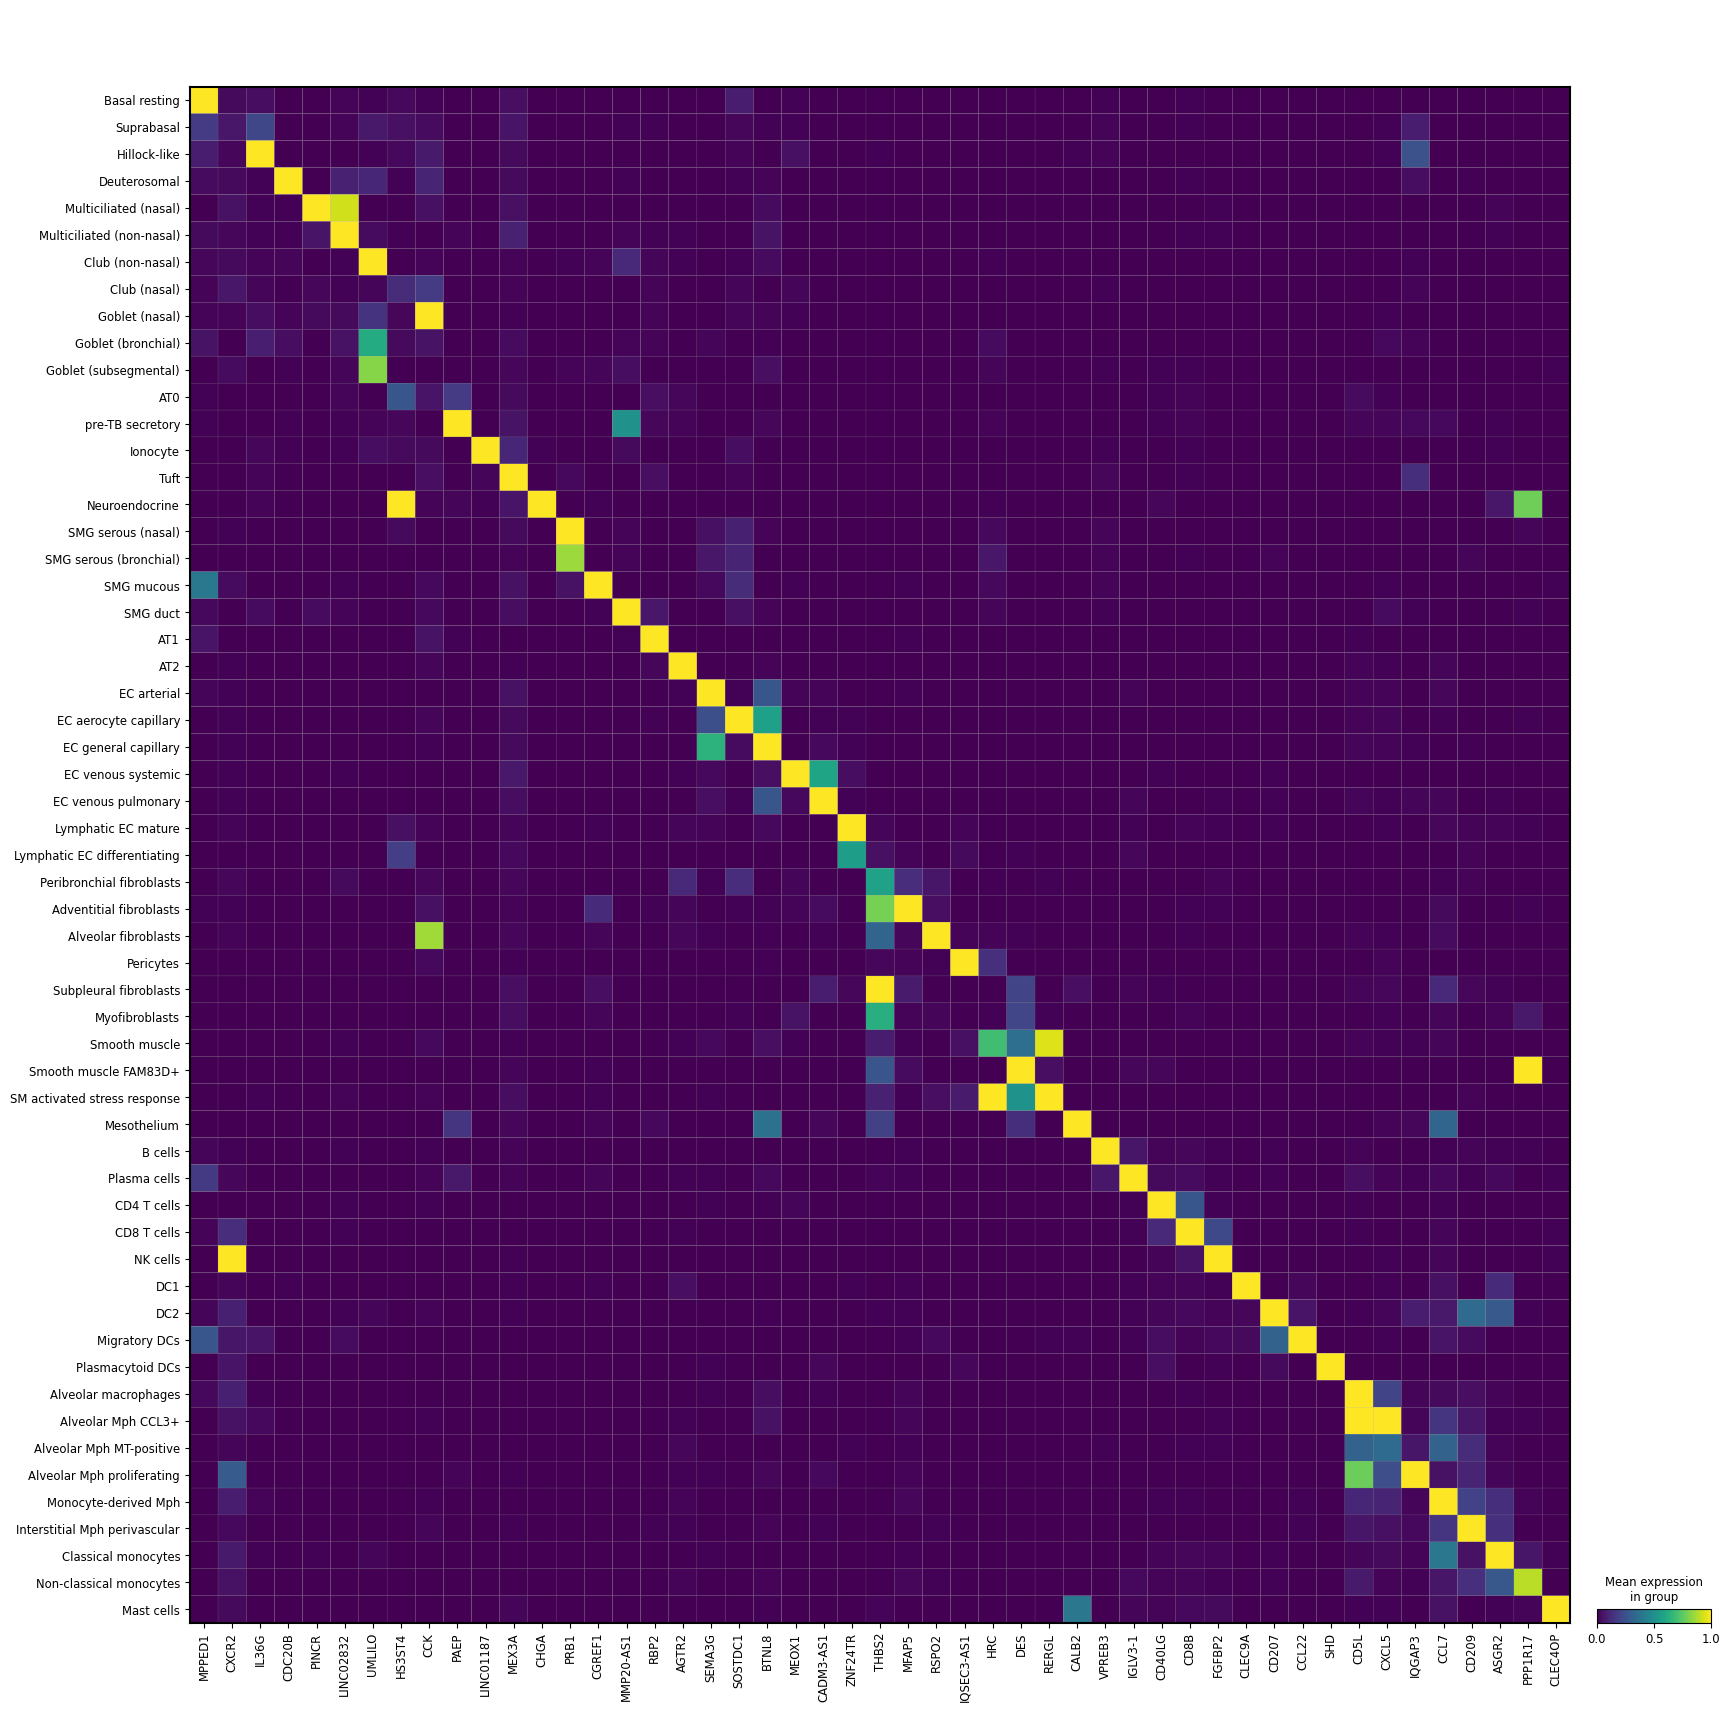

2025-04-24 13:38:01,345 - ScSherlock - INFO - Using dataset analysis results with weighted_score
2025-04-24 13:38:01,423 - ScSherlock - INFO - Plotting 49 genes for 57 cell types using dataset analysis with weighted_score


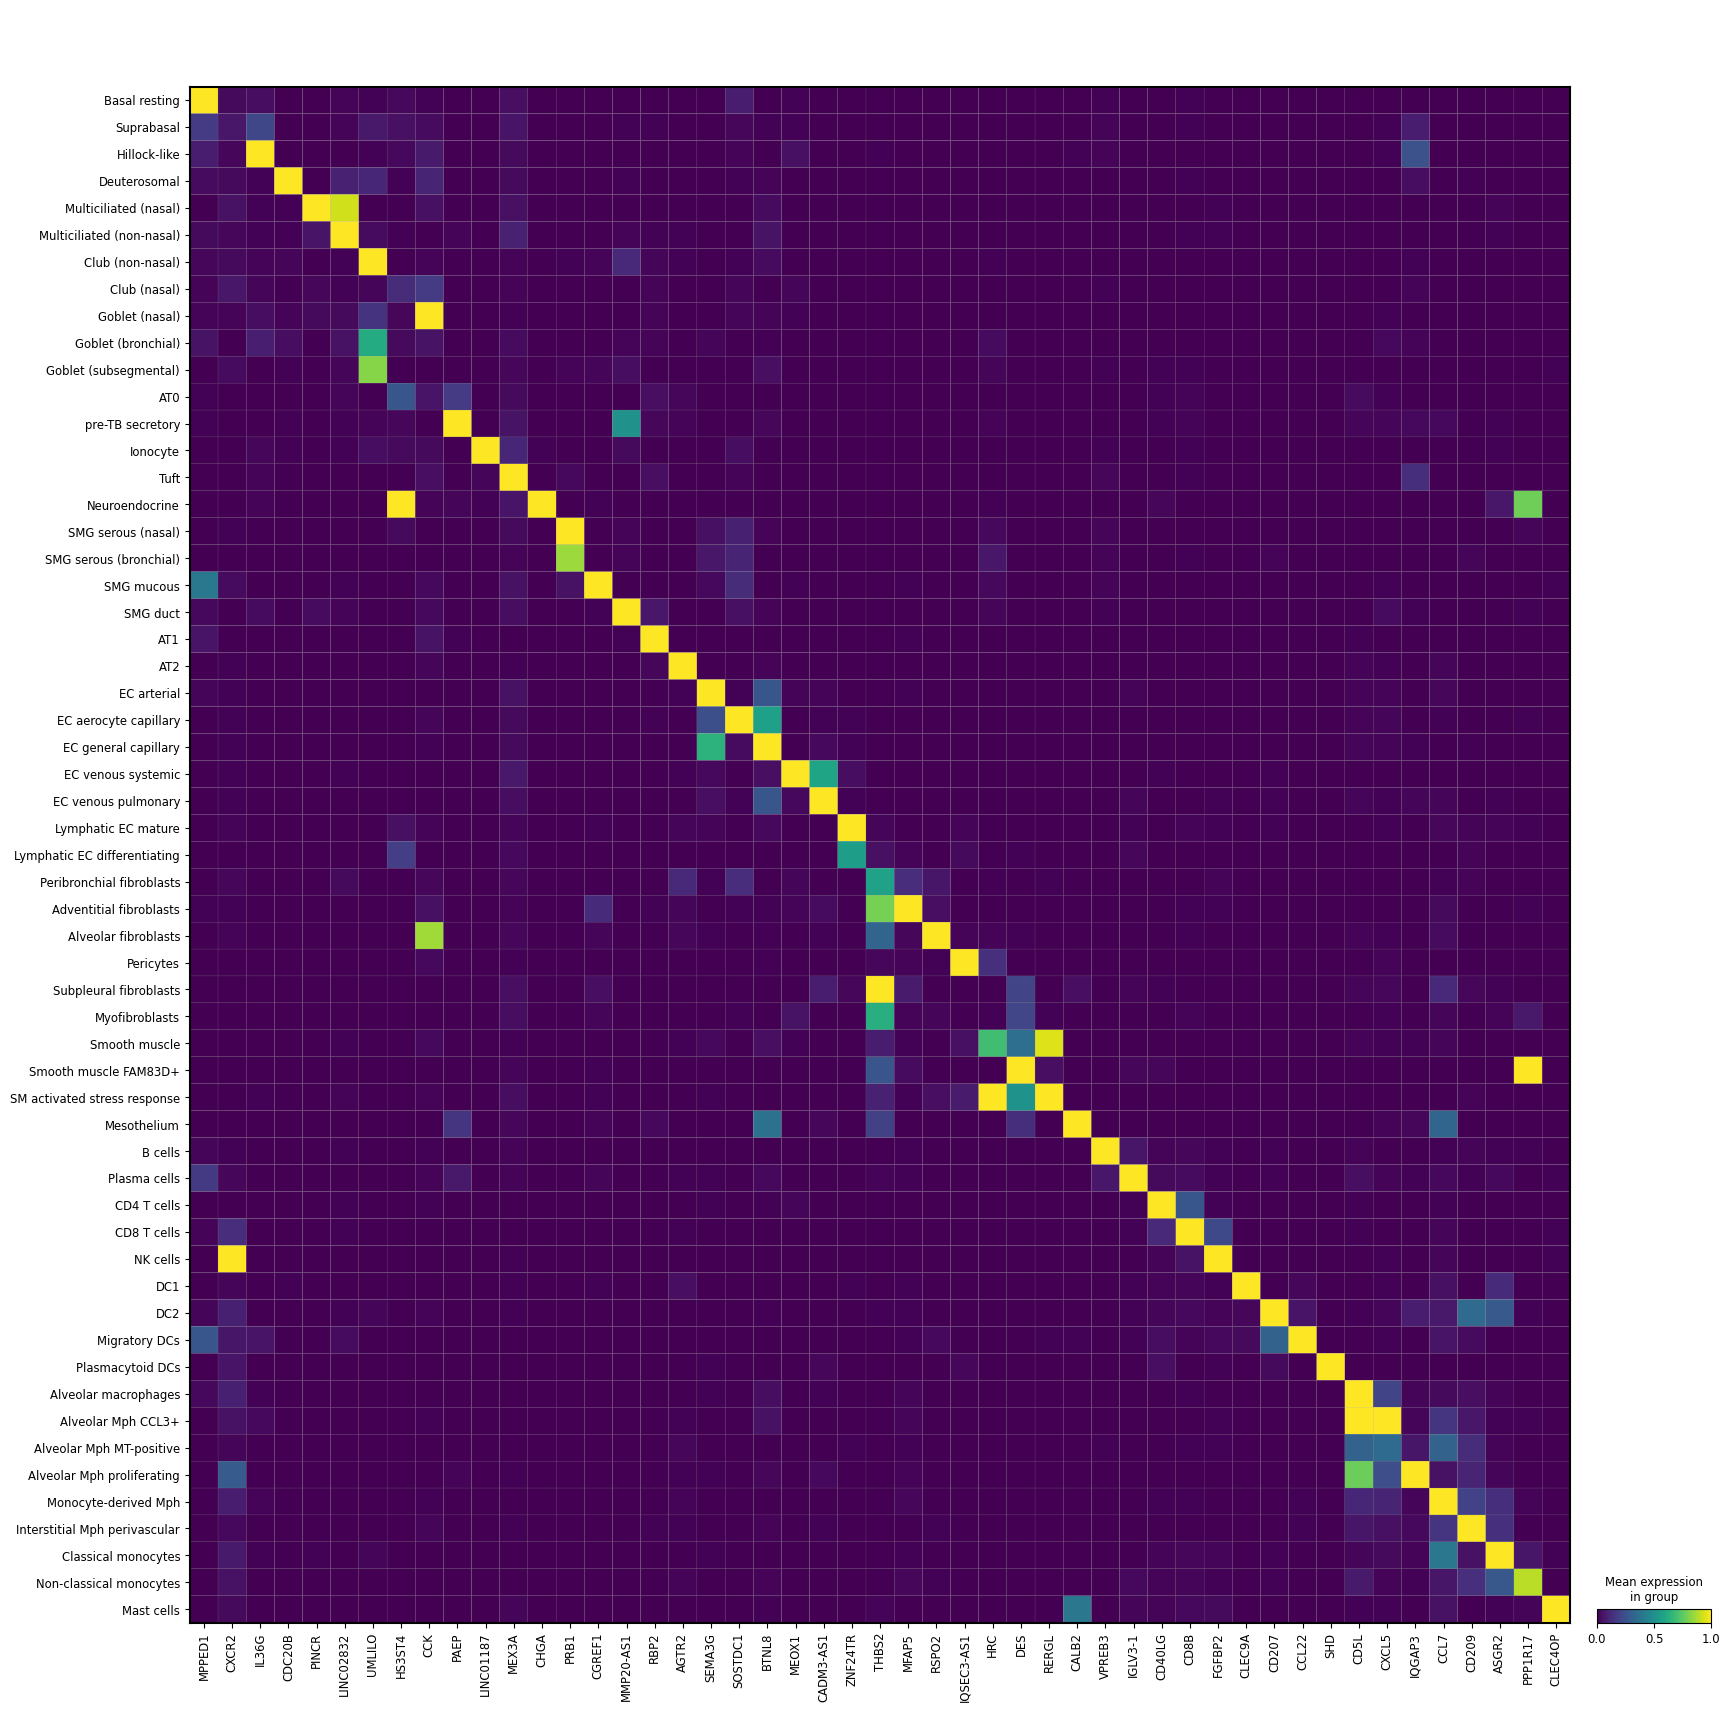

2025-04-24 13:38:03,951 - ScSherlock - INFO - Using dataset analysis results with weighted_score
2025-04-24 13:38:04,032 - ScSherlock - INFO - Plotting 49 genes for 57 cell types using dataset analysis with weighted_score


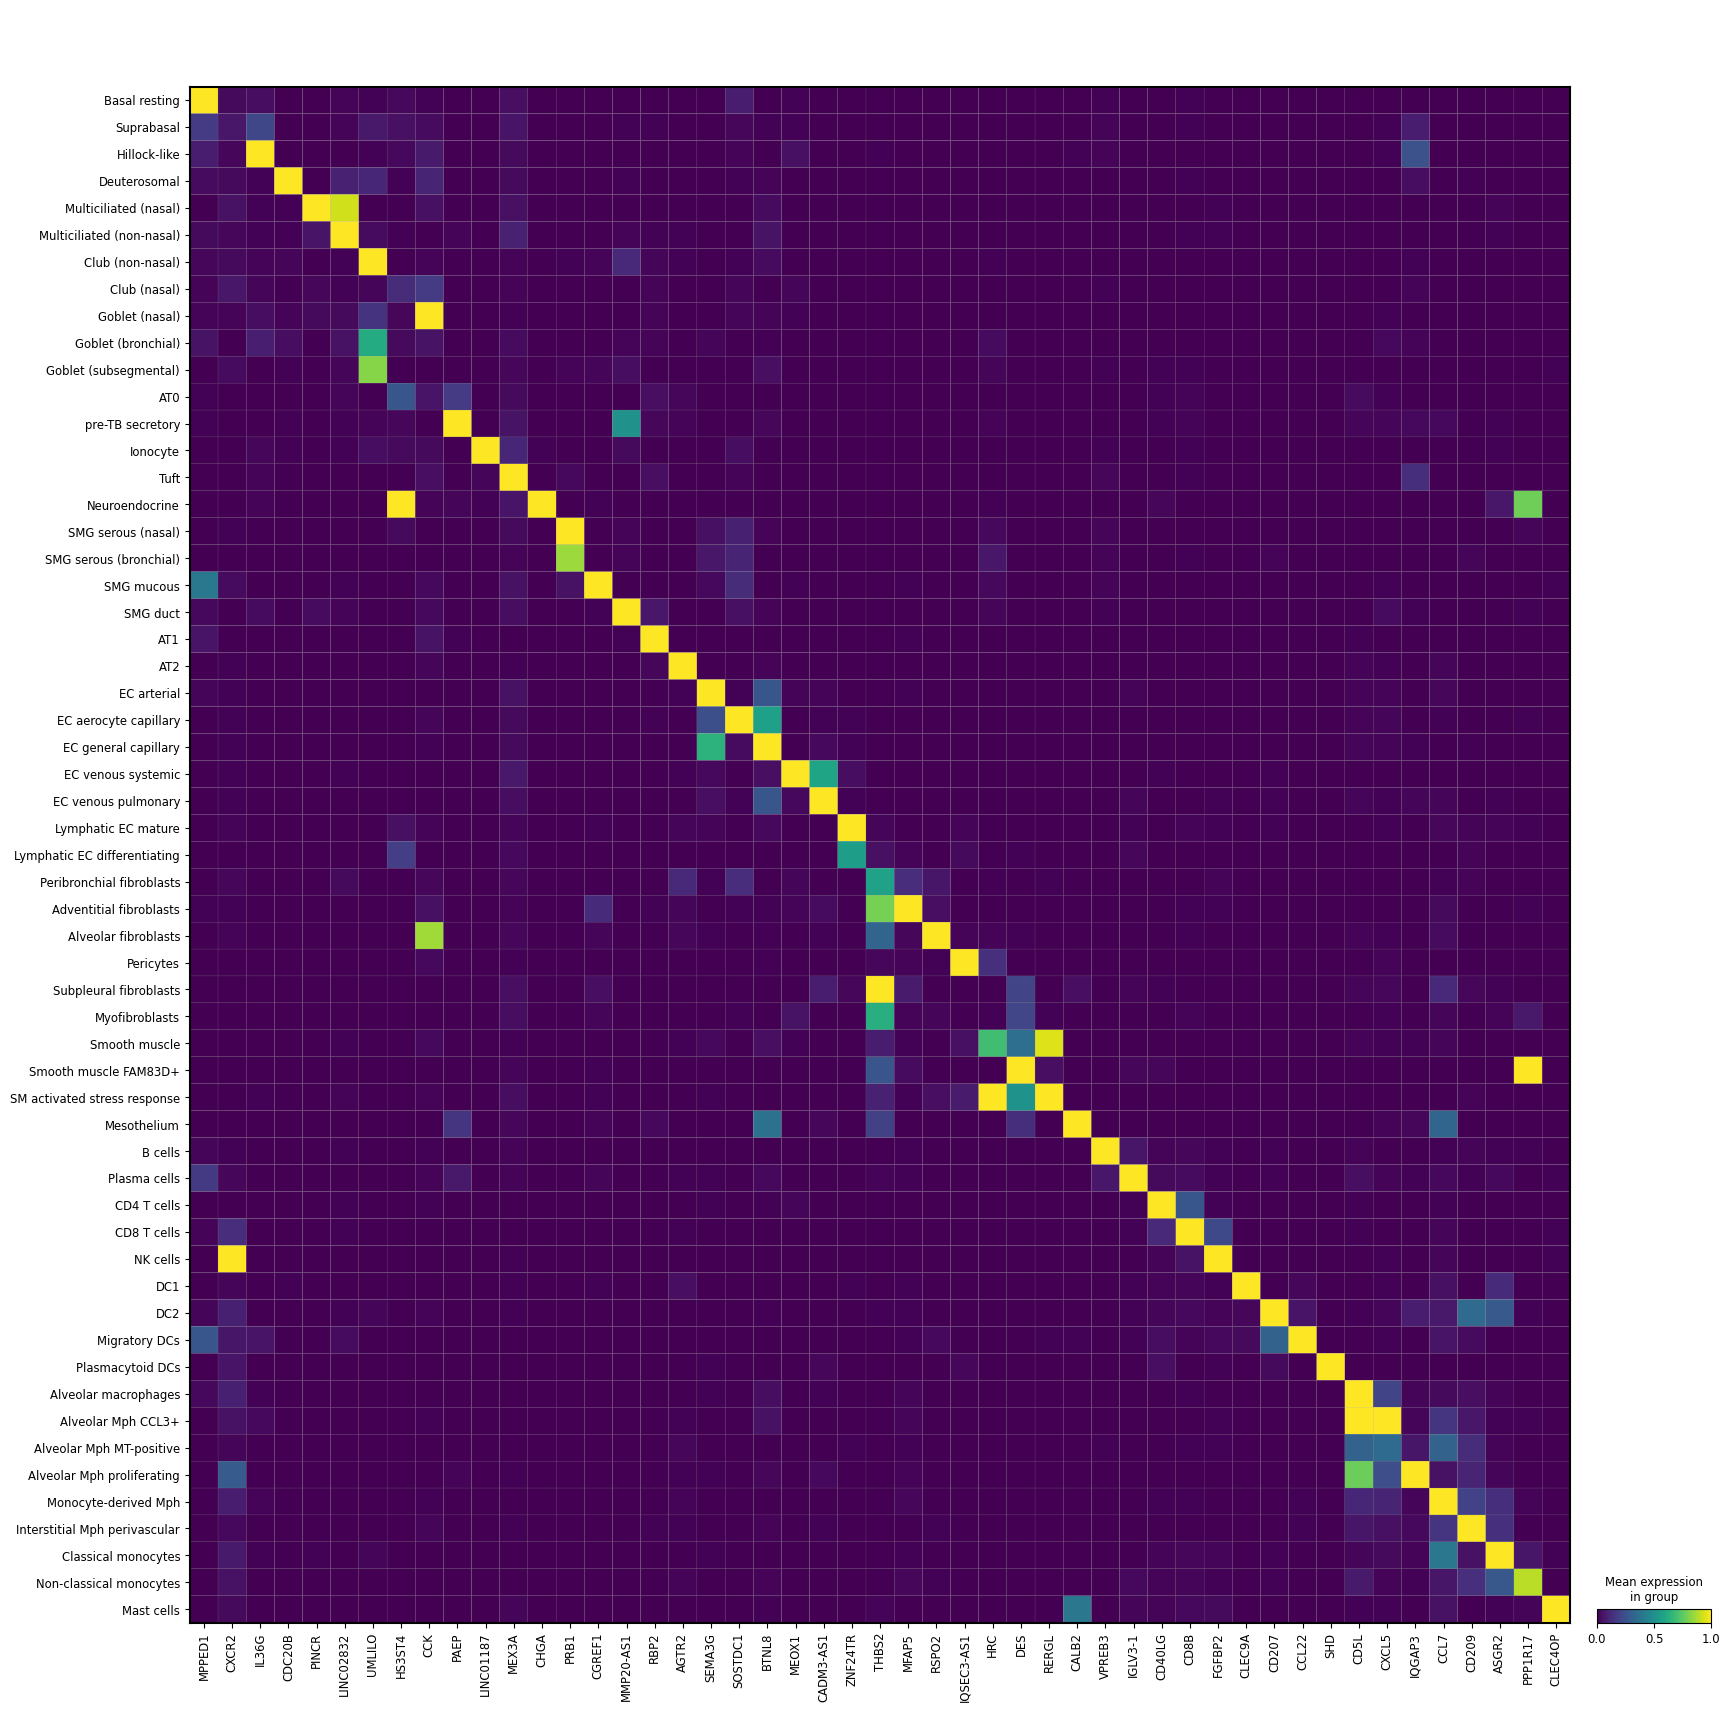

2025-04-24 13:38:06,491 - ScSherlock - INFO - Using dataset analysis results with weighted_score
2025-04-24 13:38:06,571 - ScSherlock - INFO - Plotting 49 genes for 57 cell types using dataset analysis with weighted_score


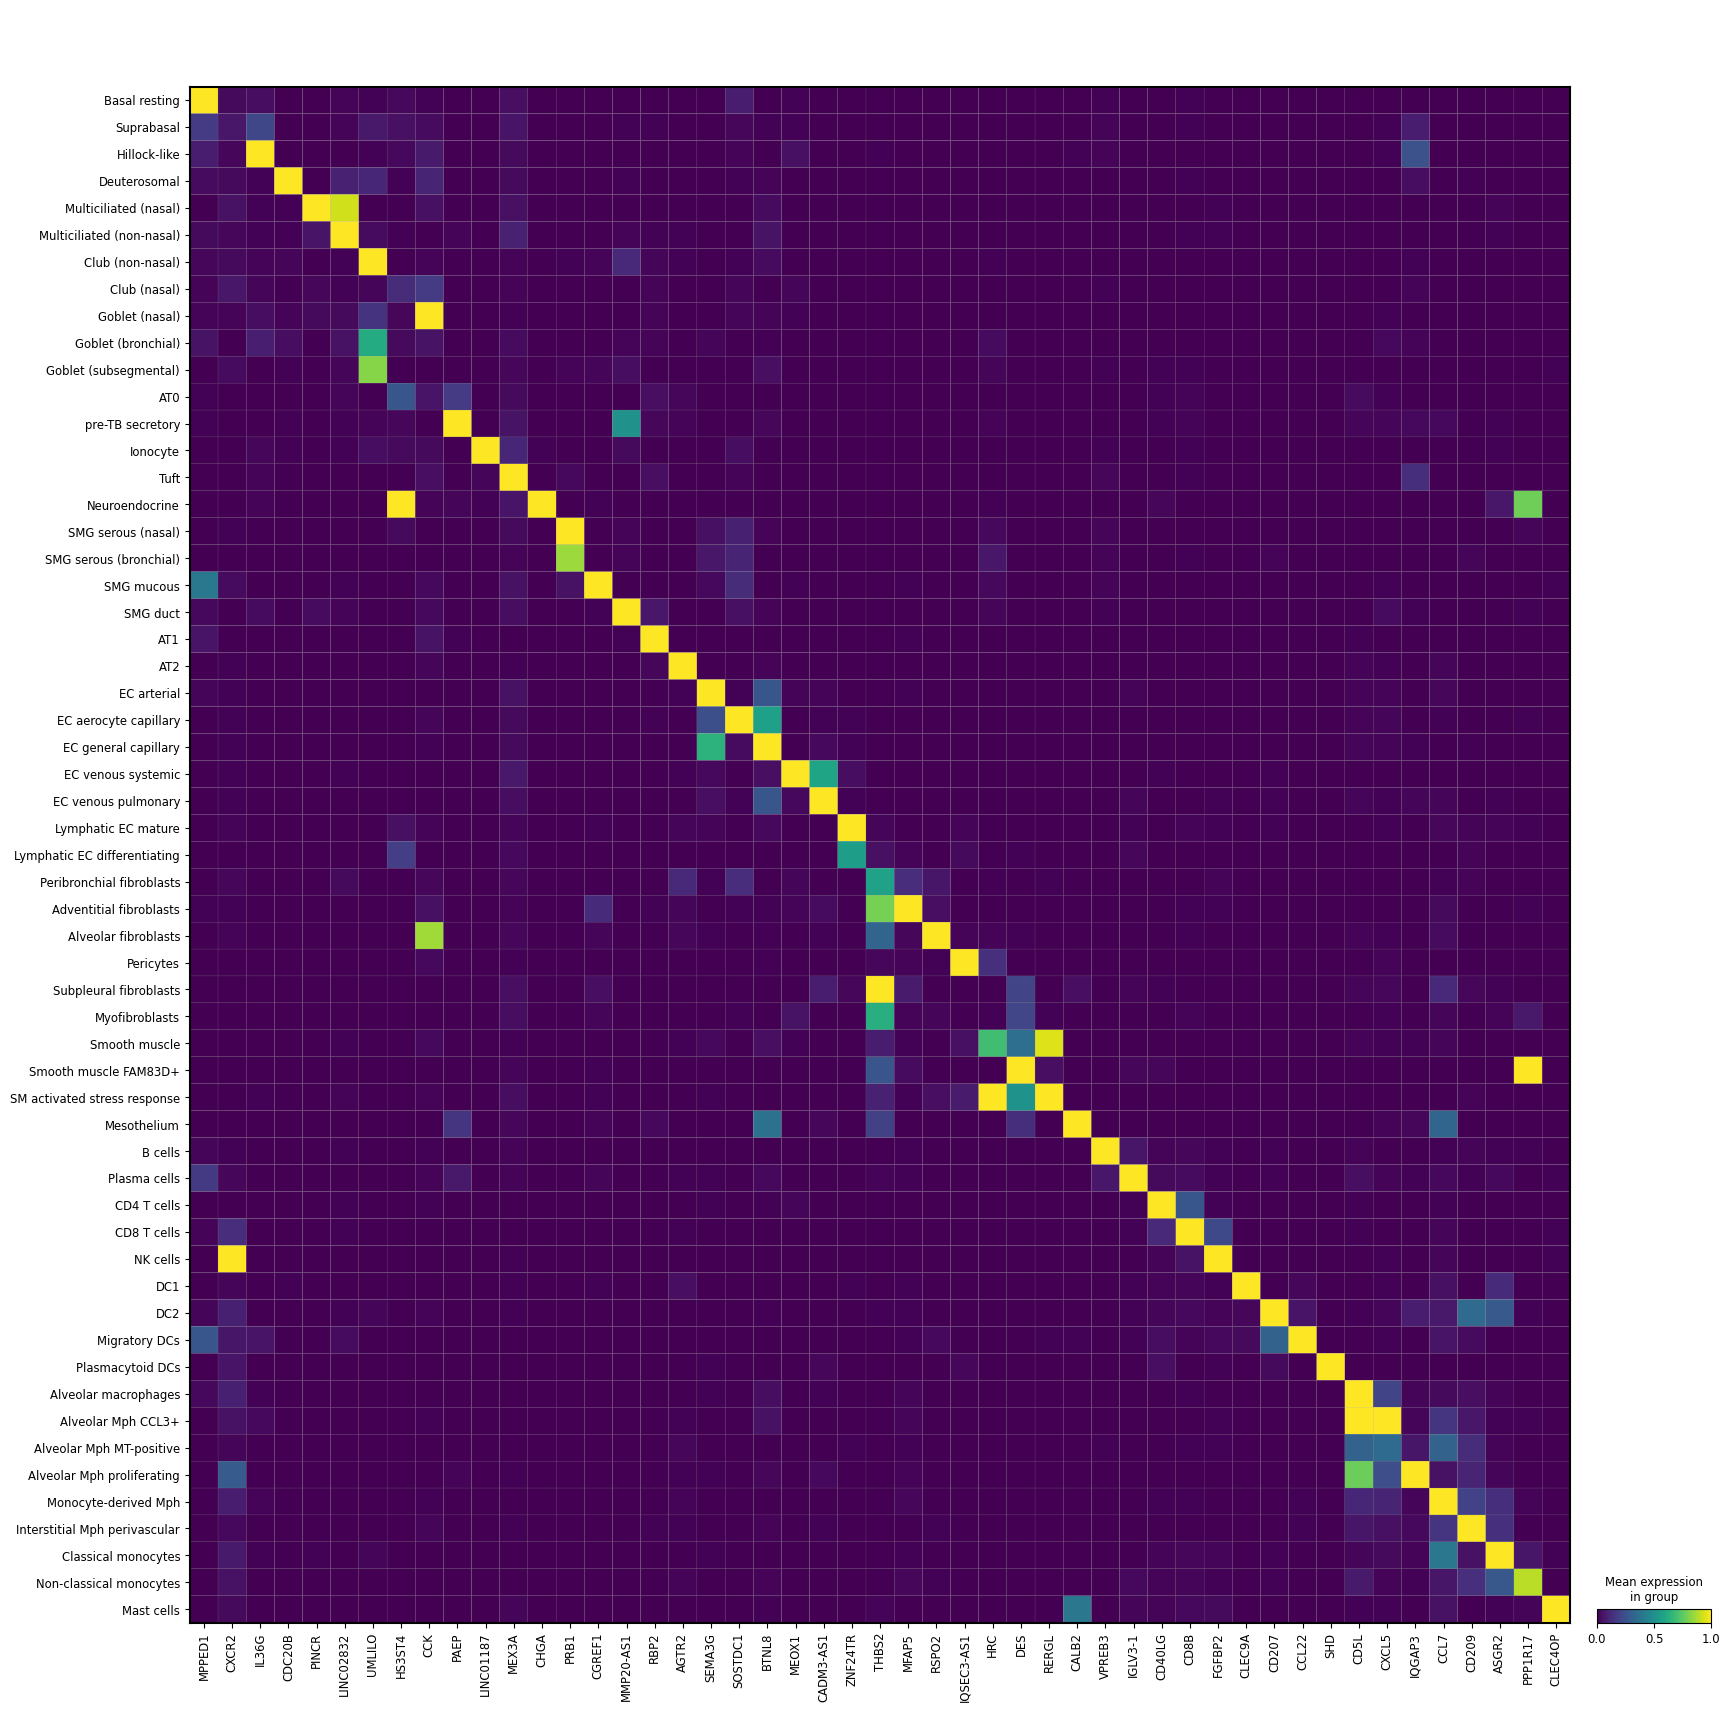

In [ ]:
for annot in annotation:
    scherlock.plot_marker_heatmap(n_genes=1, column_ctype=cell_type_column,  cutoff=0, remove_ctype_no_marker=False, dataset_column="dataset")

# unsupervised hyerarchy 

In [25]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Union, Optional, Callable
from scipy.stats import binom, percentileofscore
from adpbulk import ADPBulk
import logging
from dataclasses import dataclass
from enum import Enum
from joblib import Parallel, delayed
import scipy
import numba as nb
from sklearn.preprocessing import StandardScaler
from statsmodels.distributions.empirical_distribution import ECDF
import gc
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from collections import defaultdict

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger('ScSherlock')

In [68]:
def create_hierarchy_graph_unsupervised(self, annotation_column, max_depth=3, 
                                 linkage_method="ward", distance_metric="correlation", 
                                 min_proportion=0.05, store_graph=True, 
                                 make_compatible=True):
    """
    Create a hierarchy graph based on transcriptional similarity of cell clusters.
    
    This method:
    1. Creates pseudobulk profiles for each cluster in the annotation column
    2. Performs hierarchical clustering on these profiles
    3. Extracts a true hierarchy directly from the clustering tree
    4. Adds depth columns to the AnnData object
    5. Returns a graph compatible with the existing visualization functions
    
    Args:
        annotation_column (str): Column name in adata.obs for cell type annotations
        max_depth (int): Maximum depth of the hierarchy (default: 3)
        linkage_method (str): Method for hierarchical clustering (default: "ward")
                             Options: "single", "complete", "average", "weighted", "ward"
        distance_metric (str): Distance metric for hierarchical clustering (default: "correlation")
                              Options: "euclidean", "correlation", "cosine"
        min_proportion (float): Minimum proportion for edge weights (default: 0.05)
        store_graph (bool): Whether to store the graph in self.G (default: True)
        make_compatible (bool): Whether to create a graph compatible with visualize_hierarchy_marker (default: True)
        
    Returns:
        networkx.DiGraph: Directed graph representing cell type hierarchy
    """
    import scipy.cluster.hierarchy as sch
    import scipy.spatial.distance as ssd
    import numpy as np
    import pandas as pd
    import networkx as nx
    
    logger.info(f"Creating unsupervised hierarchy based on {annotation_column} with max depth {max_depth}")
    
    # Validate input
    if annotation_column not in self.adata.obs.columns:
        raise ValueError(f"Annotation column '{annotation_column}' not found in adata.obs")
    
    # Step 1: Create pseudobulk profiles for each cluster
    logger.info("Creating pseudobulk profiles...")
    adata_agg = ADPBulk(self.adata, annotation_column)
    pseudobulk_matrix = adata_agg.fit_transform()
    sample_meta = adata_agg.get_meta()
    
    # Ensure annotation column is in sample_meta
    if annotation_column not in sample_meta.columns:
        raise ValueError(f"Failed to create pseudobulk profiles with {annotation_column}")
    
    # Set index to annotation column
    pseudobulk_matrix.set_index(sample_meta[annotation_column], inplace=True)
    
    # Store original cell type names
    cell_types = list(pseudobulk_matrix.index)
    n_samples = len(cell_types)
    
    # Step 2: Perform hierarchical clustering
    logger.info(f"Performing hierarchical clustering using {linkage_method} linkage and {distance_metric} distance...")
    
    # Compute distance matrix
    if distance_metric == "correlation":
        # For correlation, higher values mean more similar, so we convert to distance
        corr_matrix = pseudobulk_matrix.T.corr()
        dist_matrix = 1 - corr_matrix
        # Handle any NA values
        dist_matrix = dist_matrix.fillna(1.0)
        # Convert to condensed form
        condensed_dist = ssd.squareform(dist_matrix)
    elif distance_metric == "cosine":
        # Compute pairwise cosine distances
        condensed_dist = ssd.pdist(pseudobulk_matrix, metric="cosine")
    else:
        # Default to euclidean
        condensed_dist = ssd.pdist(pseudobulk_matrix, metric="euclidean")
    
    # Perform hierarchical clustering
    Z = sch.linkage(condensed_dist, method=linkage_method)
    
    # Step 3: Extract true hierarchy from linkage matrix
    logger.info("Extracting hierarchical structure from dendrogram...")
    
    # Initialize a dictionary to track nodes and their contents
    # Initially, each leaf node contains just one cell type
    node_contents = {i: [cell_types[i]] for i in range(n_samples)}
    
    # Initialize a dictionary to store parent-child relationships
    hierarchy = {}
    
    # Process the linkage matrix to build the hierarchy
    # Each row in Z represents a merge operation
    for i, (left, right, distance, _) in enumerate(Z):
        # New cluster ID is n_samples + the current iteration
        new_id = n_samples + i
        
        # Convert from float to int (scipy returns floats)
        left = int(left)
        right = int(right)
        
        # Store the merge information
        hierarchy[new_id] = {
            'left': left,
            'right': right,
            'distance': distance,
            'children': node_contents[left] + node_contents[right]
        }
        
        # Update the node contents
        node_contents[new_id] = node_contents[left] + node_contents[right]
    
    # Find the root node (the last merge)
    root_node = n_samples + len(Z) - 1
    
    # We need to ensure that each parent layer has fewer nodes than child layers
    # Start with a small number of clusters at the top level and increase for deeper levels
    
    # Calculate number of clusters for each depth
    # For max_depth=3: [2, 4, 8] or similar
    n_clusters_by_depth = {}
    
    # Start with 2 clusters at top level (or adjust based on data size)
    base_clusters = max(2, len(cell_types) // (2**(max_depth+1)))
    
    # Ensure we have at least one more cluster at each deeper level
    for depth in range(1, max_depth + 1):
        # Number of clusters increases with depth but stays below number of cell types
        n_clusters_by_depth[depth] = min(
            # Increase exponentially with depth
            base_clusters * (2**(depth-1)),
            # But never exceed the number of cell types
            max(depth, len(cell_types) - (max_depth - depth))
        )
    
    # For debugging
    logger.info(f"Number of clusters by depth: {n_clusters_by_depth}")
    
    # Verify that we have increasing numbers of clusters with depth
    for depth in range(1, max_depth):
        if n_clusters_by_depth[depth] >= n_clusters_by_depth[depth+1]:
            # Adjust to ensure increasing clusters with depth
            n_clusters_by_depth[depth+1] = n_clusters_by_depth[depth] + 1
            logger.info(f"Adjusted clusters at depth {depth+1} to {n_clusters_by_depth[depth+1]}")
    
    # Create cluster assignments at each depth using the calculated number of clusters
    cluster_labels = {}
    for depth in range(1, max_depth + 1):
        # Use the pre-calculated number of clusters for this depth
        n_clusters = n_clusters_by_depth[depth]
        labels = sch.fcluster(Z, n_clusters, criterion='maxclust')
        
        # Store labels with cell types as index
        cluster_labels[depth] = pd.Series(labels, index=cell_types)
        
        # Log the number of unique clusters at this depth
        unique_clusters = len(np.unique(labels))
        logger.info(f"Depth {depth}: {unique_clusters} unique clusters (target: {n_clusters})")
    
    # Add depth columns to AnnData object
    for depth in range(1, max_depth + 1):
        depth_column = f"{annotation_column}_depth{depth}"
        # Create cluster names in format "Cluster_depth_id"
        cluster_names = {
            cell_type: f"Cluster_{depth}_{cluster_labels[depth][cell_type]}" 
            for cell_type in cell_types
        }
        
        # Add to AnnData
        self.adata.obs[depth_column] = self.adata.obs[annotation_column].map(
            lambda x: cluster_names.get(x, f"Unknown_{depth}")
        )
        # Convert to categorical
        self.adata.obs[depth_column] = self.adata.obs[depth_column].astype('category')
        logger.info(f"Added column {depth_column} to AnnData.obs")
    
    # Step 4: Create the hierarchy graph
    logger.info("Building networkx graph from hierarchy...")
    G = nx.DiGraph()
    
    # Add root node
    G.add_node('root')
    G.nodes['root']['level'] = 0
    G.nodes['root']['label'] = 'ROOT'
    
    # Function to add a cluster to the graph if it doesn't exist
    def add_cluster_node(cluster_name, depth):
        if not G.has_node(cluster_name):
            G.add_node(cluster_name)
            G.nodes[cluster_name]['level'] = depth
            G.nodes[cluster_name]['annotation'] = f"{annotation_column}_depth{depth}"
            # Extract cluster ID from name
            cluster_id = cluster_name.split('_')[-1]
            G.nodes[cluster_name]['label'] = cluster_id
    
    # Create cluster nodes for each depth level
    for depth in range(1, max_depth + 1):
        # Get unique clusters at this depth
        unique_clusters = cluster_labels[depth].unique()
        
        # Create nodes for each cluster
        for cluster_id in unique_clusters:
            cluster_name = f"Cluster_{depth}_{cluster_id}"
            add_cluster_node(cluster_name, depth)
            
            # Get cell types in this cluster
            cluster_cell_types = [ct for ct in cell_types if cluster_labels[depth][ct] == cluster_id]
            
            # If this is the deepest level, connect to cell types
            if depth == max_depth:
                for cell_type in cluster_cell_types:
                    if make_compatible:
                        # For compatibility with visualize_hierarchy_marker:
                        # Use the cell type as the node name, but add cluster prefix to make it unique
                        leaf_node = cell_type
                    else:
                        # Original approach: use cluster name + cell type as node name
                        leaf_node = f"{cluster_name}_{cell_type}"
                    
                    G.add_node(leaf_node)
                    G.nodes[leaf_node]['level'] = max_depth + 1
                    G.nodes[leaf_node]['annotation'] = annotation_column
                    G.nodes[leaf_node]['label'] = cell_type
                    
                    # Add edge from cluster to cell type
                    G.add_edge(cluster_name, leaf_node)
                    G.edges[cluster_name, leaf_node]['weight'] = 1.0 / len(cluster_cell_types)
                    G.nodes[leaf_node]['proportion'] = 1.0 / len(cluster_cell_types)
    
    # Connect clusters across different depths
    # Starting with root to depth 1
    depth1_clusters = set([f"Cluster_1_{cid}" for cid in cluster_labels[1].unique()])
    for cluster in depth1_clusters:
        G.add_edge('root', cluster)
        G.edges['root', cluster]['weight'] = 1.0 / len(depth1_clusters)
        G.nodes[cluster]['proportion'] = 1.0 / len(depth1_clusters)
    
    # Connect between adjacent depth levels
    for depth in range(1, max_depth):
        # Get clusters at current and next depth
        current_depth_labels = cluster_labels[depth]
        next_depth_labels = cluster_labels[depth + 1]
        
        # For each cluster at the current depth
        for current_cluster_id in current_depth_labels.unique():
            current_cluster = f"Cluster_{depth}_{current_cluster_id}"
            
            # Find cell types in this cluster
            cell_types_in_current = [ct for ct in cell_types if current_depth_labels[ct] == current_cluster_id]
            
            # Find which clusters these cell types belong to in the next depth
            next_clusters = {}
            for ct in cell_types_in_current:
                next_cluster_id = next_depth_labels[ct]
                next_cluster = f"Cluster_{depth+1}_{next_cluster_id}"
                
                if next_cluster not in next_clusters:
                    next_clusters[next_cluster] = []
                next_clusters[next_cluster].append(ct)
            
            # Connect current cluster to its child clusters at the next depth
            for next_cluster, contained_cell_types in next_clusters.items():
                # Calculate proportion based on number of cell types
                proportion = len(contained_cell_types) / len(cell_types_in_current)
                
                # Only add edge if proportion exceeds minimum
                if proportion >= min_proportion:
                    G.add_edge(current_cluster, next_cluster)
                    G.edges[current_cluster, next_cluster]['weight'] = proportion
                    
                    # Update proportion attribute in child node
                    if 'proportion' not in G.nodes[next_cluster]:
                        G.nodes[next_cluster]['proportion'] = proportion
    
    # Step 5: Clean up the graph
    # Remove isolated nodes
    isolated_nodes = [node for node in G.nodes() if G.degree(node) == 0 and node != 'root']
    G.remove_nodes_from(isolated_nodes)
    
    # Verify connected components
    if not nx.is_weakly_connected(G):
        logger.warning("The hierarchy graph is not fully connected")
    
    # Store graph in instance if requested
    if store_graph:
        self.G = G
        logger.info("Stored hierarchy graph in ScSherlock.G")
    
    logger.info(f"Created hierarchy graph with {len(G.nodes())} nodes and {len(G.edges())} edges")
    return G

In [16]:
G = scherlock.create_hierarchy_graph_unsupervised( "curated_finest", max_depth=3, 
                                 linkage_method="ward", distance_metric="correlation", 
                                 min_proportion=0.05, store_graph=True)

NameError: name 'scherlock' is not defined

In [ ]:
scherlock.visualize_hierarchy( "curated_finest", marker_column=None, 
                               figsize=(20, 12), output_file=None, color_by_depth=False, color_by_cluster=True)

NameError: name 'scherlock' is not defined

In [64]:
scherlock.adata.obs

,suspension_type,donor_id,is_primary_data,assay_ontology_term_id,cell_type_ontology_term_id,development_stage_ontology_term_id,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,tissue_ontology_term_id,organism_ontology_term_id,...,development_stage,observation_joinid,curated_finest,split,donor_id_simplified,curated_finest_depth1,curated_finest_depth2,curated_finest_depth3,curated_finest_depth4,curated_finest_depth5
P3_5_TTAGGCACAGCATGAG,cell,homosapiens_None_2023_None_sikkemalisa_001_d10...,False,EFO:0009899,CL:0000583,HsapDv:0000145,PATO:0000461,unknown,UBERON:0008946,NCBITaxon:9606,...,51-year-old stage,PRt|`xY}(B,Alveolar macrophages,train,P1,Cluster_1_2,Cluster_2_4,Cluster_3_7,Cluster_4_14,Cluster_5_26
CAGCATATCACTGGGC-SC59,cell,homosapiens_None_2023_None_sikkemalisa_001_d10...,False,EFO:0009899,CL:0000583,HsapDv:0000112,PATO:0000461,HANCESTRO:0005,UBERON:0008946,NCBITaxon:9606,...,18-year-old stage,m!|5qaUn!@,Alveolar macrophages,train,P2,Cluster_1_2,Cluster_2_4,Cluster_3_7,Cluster_4_14,Cluster_5_26
AACTCTTGTCACAAGG_SC20,cell,homosapiens_None_2023_None_sikkemalisa_001_d10...,False,EFO:0009899,CL:0000583,HsapDv:0000151,PATO:0000461,HANCESTRO:0010,UBERON:0008946,NCBITaxon:9606,...,57-year-old stage,w5@`$x@2U`,Alveolar macrophages,train,P3,Cluster_1_2,Cluster_2_4,Cluster_3_7,Cluster_4_14,Cluster_5_26
CATTGCCCACATTCGA_SC144,cell,homosapiens_None_2023_None_sikkemalisa_001_d10...,False,EFO:0009922,CL:0000583,HsapDv:0000119,PATO:0000461,unknown,UBERON:0008946,NCBITaxon:9606,...,25-year-old stage,>bR_d(5VVv,Alveolar macrophages,train,P4,Cluster_1_2,Cluster_2_4,Cluster_3_7,Cluster_4_14,Cluster_5_26
GCAAACTCAGCTGCTG_SC20,cell,homosapiens_None_2023_None_sikkemalisa_001_d10...,False,EFO:0009899,CL:0000583,HsapDv:0000151,PATO:0000461,HANCESTRO:0010,UBERON:0008946,NCBITaxon:9606,...,57-year-old stage,5~5I&^ncdG,Alveolar macrophages,train,P3,Cluster_1_2,Cluster_2_4,Cluster_3_7,Cluster_4_14,Cluster_5_26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CACAGTAAGAACTGTA-1-HCATisStab7747198,cell,homosapiens_None_2023_None_sikkemalisa_001_d10...,False,EFO:0009899,CL:0000451,HsapDv:0000241,PATO:0000461,HANCESTRO:0005,UBERON:0008946,NCBITaxon:9606,...,seventh decade stage,uH-clc#`2R,Migratory DCs,train,P30,Cluster_1_2,Cluster_2_4,Cluster_3_8,Cluster_4_16,Cluster_5_29
TAAGAGAAGTTAGCGG-SC156,cell,homosapiens_None_2023_None_sikkemalisa_001_d10...,False,EFO:0009899,CL:0000451,HsapDv:0000117,PATO:0000461,HANCESTRO:0005,UBERON:0008946,NCBITaxon:9606,...,23-year-old stage,(X{$U%i6-t,Migratory DCs,train,P14,Cluster_1_2,Cluster_2_4,Cluster_3_8,Cluster_4_16,Cluster_5_29
TACACGAGTTGCGCAC-1-HCATisStab7747198,cell,homosapiens_None_2023_None_sikkemalisa_001_d10...,False,EFO:0009899,CL:0000451,HsapDv:0000241,PATO:0000461,HANCESTRO:0005,UBERON:0008946,NCBITaxon:9606,...,seventh decade stage,N`6wfHEtTf,Migratory DCs,train,P30,Cluster_1_2,Cluster_2_4,Cluster_3_8,Cluster_4_16,Cluster_5_29
P1_3_TGCTGCTGTTACCGAT,cell,homosapiens_None_2023_None_sikkemalisa_001_d10...,False,EFO:0009899,CL:0000451,HsapDv:0000169,PATO:0000461,HANCESTRO:0005,UBERON:0008946,NCBITaxon:9606,...,75-year-old stage,LMW-H`cg27,Migratory DCs,train,P15,Cluster_1_2,Cluster_2_4,Cluster_3_8,Cluster_4_16,Cluster_5_29


In [99]:
scherlock.run(column_ctype="curated_finest", method='empiric', bootstrap=False)

2025-04-25 12:07:45,797 - ScSherlock - INFO - ScSherlock already run with empiric method for curated_finest. Found markers for 44/50 cell types


{'Alveolar macrophages': 'ENSG00000236341.1',
 'NK cells': 'KIR3DL1',
 'AT2': 'CPB2',
 'Alveolar Mph CCL3+': 'SPOCD1',
 'Basal': 'SOSTDC1',
 'EC venous pulmonary': 'SULT1E1',
 'CD8 T cells': 'TRDV1',
 'EC arterial': 'ENSG00000233760.3',
 'Peribronchial fibroblasts': 'FGFR4',
 'CD4 T cells': 'LINC00402',
 'AT1': 'RBP2',
 'Multiciliated': 'GSTA2',
 'Plasma cells': 'IGHV3-30',
 'Hillock-like': 'RHCG',
 'Goblet': 'PADI1',
 'Club': 'LINC02568',
 'SM activated stress response': 'PLN',
 'Classical monocytes': 'SERPINB2',
 'Monocyte-derived Mph': 'MMP8',
 'SMG serous': 'LPO',
 'EC venous systemic': 'GABRA2',
 'Non-classical monocytes': 'PPP1R17',
 'EC general capillary': 'CD300LG',
 'Adventitial fibroblasts': 'ADAMTS16',
 'Lymphatic EC mature': 'LINC00636',
 'EC aerocyte capillary': 'SOSTDC1',
 'pre-TB secretory': 'CRISP3',
 'Smooth muscle': 'RERGL',
 'Alveolar fibroblasts': 'COL6A5',
 'Neuroendocrine': 'SST',
 'DC2': 'CDH17',
 'DC1': 'XCR1',
 'B cells': 'ENSG00000250850.3',
 'Mast cells': 'LI

2025-04-25 13:01:50,170 - ScSherlock - INFO - Found dataset analysis for curated_finest with weighted_score
2025-04-25 13:01:50,171 - ScSherlock - INFO - Using dataset analysis results for curated_finest
2025-04-25 13:01:50,172 - ScSherlock - INFO - Found empirical marker scores for curated_finest_depth1
2025-04-25 13:01:50,172 - ScSherlock - INFO - Found empirical marker scores for curated_finest_depth2
2025-04-25 13:01:50,172 - ScSherlock - INFO - Found empirical marker scores for curated_finest_depth3


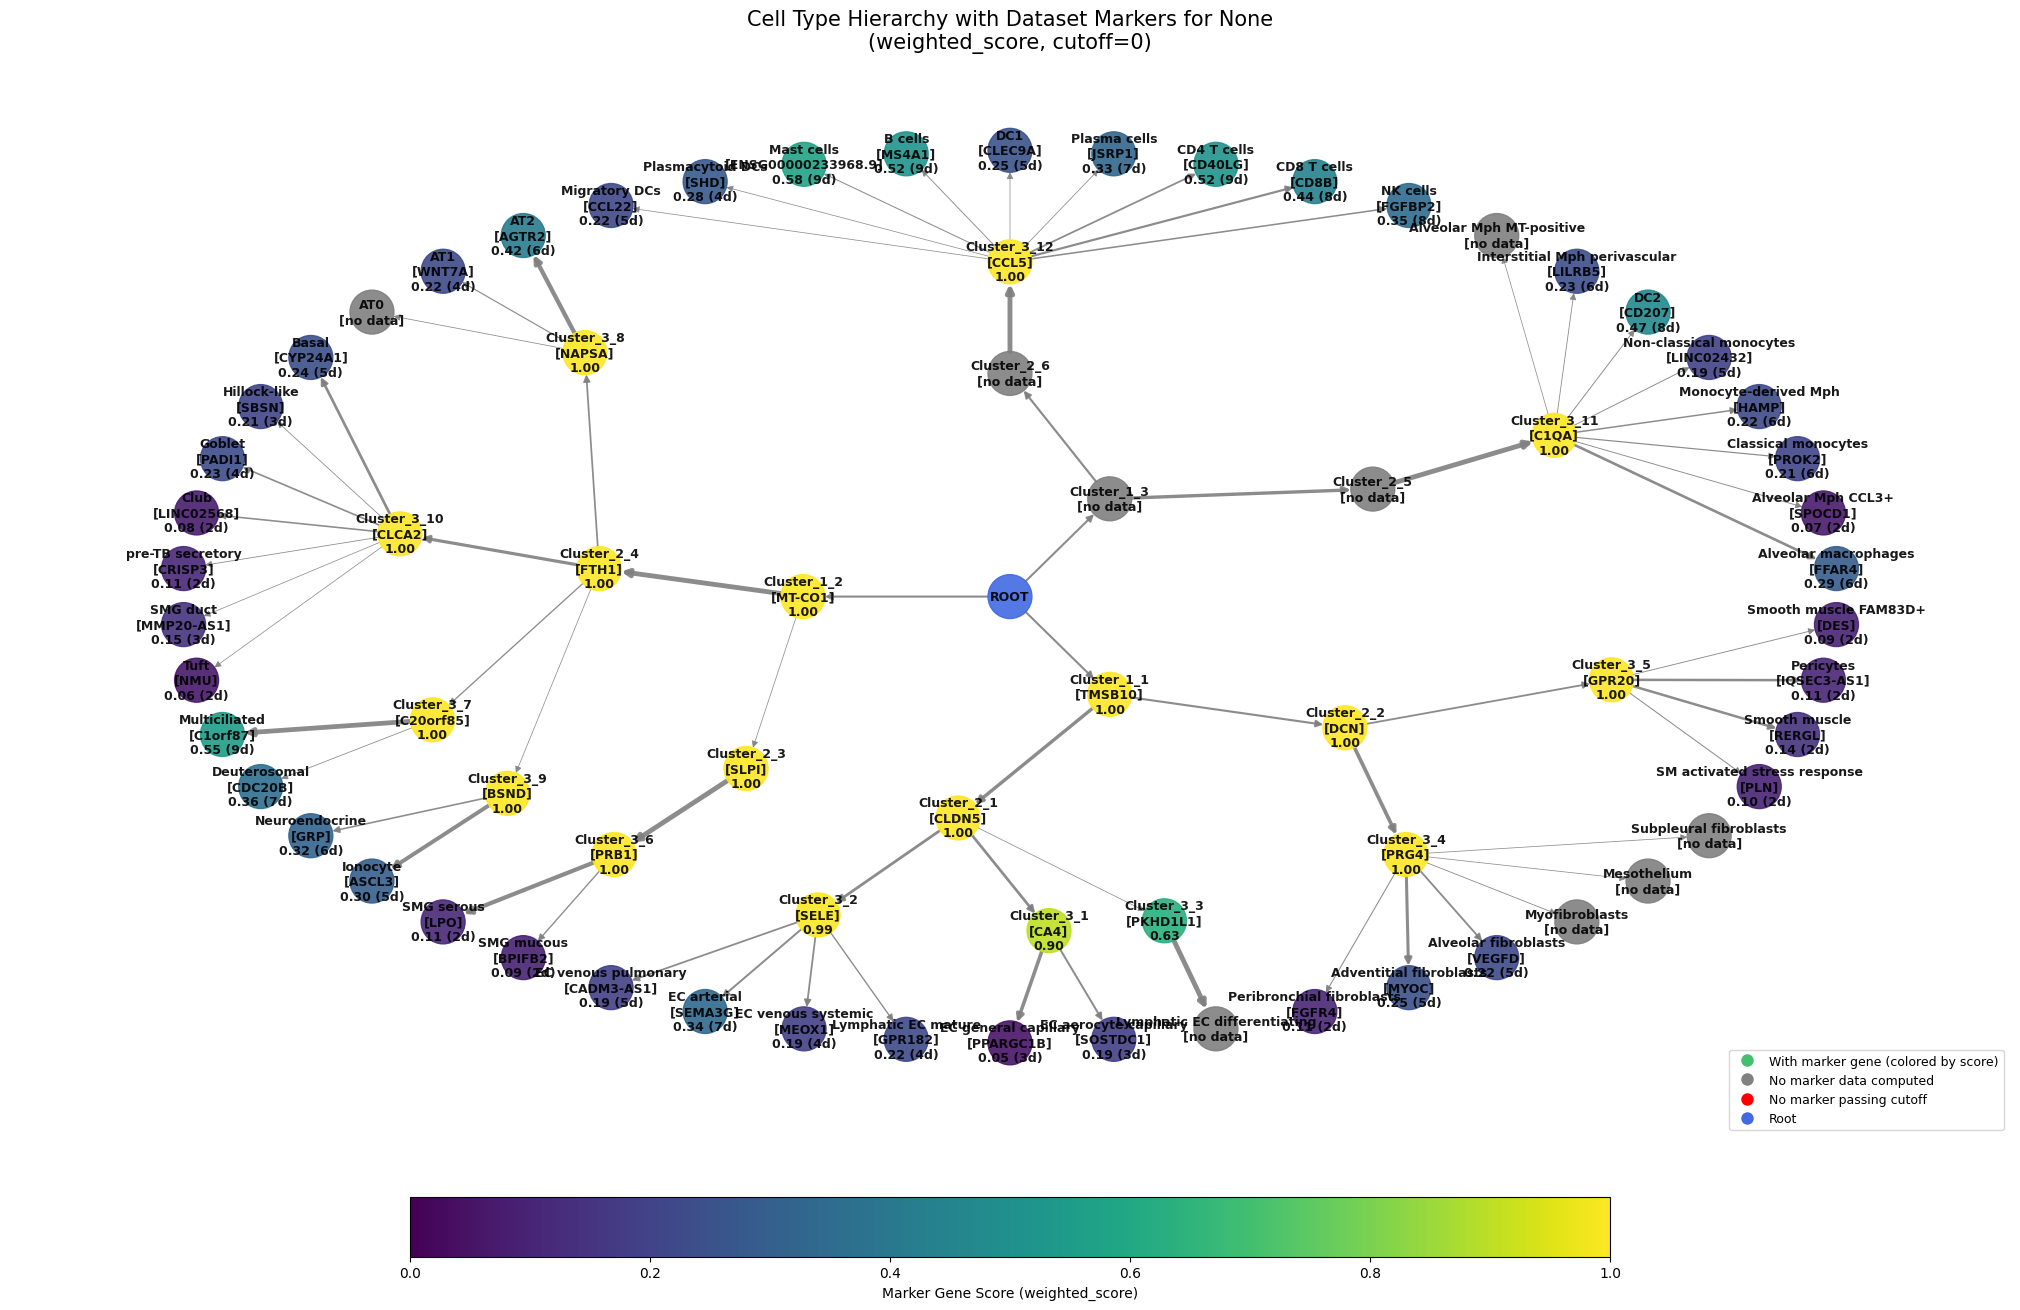

In [101]:
fig = scherlock.visualize_hierarchy_marker(cutoff=0, dataset_column="dataset")

In [83]:
scherlock.sorted_empirical_table.keys()

dict_keys(['curated_finest', 'curated_finest_depth1', 'curated_finest_depth2'])

In [84]:
def visualize_hierarchy_marker_enhanced(self, column_ctype, n_genes=1, cutoff=0, 
                              cmap='viridis', figsize=(20, 12), output_file=None, 
                              color_by_cluster=True, verbose=False):
    """
    Enhanced visualization of marker genes on a hierarchy graph.
    
    This method properly matches markers to cell types in the graph, regardless of
    whether they are from the original annotation or from cluster-level annotations.
    
    Args:
        column_ctype: Column name in adata.obs for cell type annotations with marker information
        n_genes (int): Number of top genes to display for each cell type (default: 1)
        cutoff (float): Minimum score cutoff for including genes (default: 0)
        cmap (str): Colormap for node coloring (default: 'viridis')
        figsize (tuple): Figure size (width, height) (default: (20, 12))
        output_file (str, optional): Path to save the figure (default: None)
        color_by_cluster (bool): Whether to color nodes by their cluster assignment (default: True)
        verbose (bool): Print detailed debugging information (default: False)
            
    Returns:
        matplotlib.figure.Figure: The figure containing the visualization
    """
    import matplotlib.pyplot as plt
    import networkx as nx
    from networkx.drawing.nx_agraph import graphviz_layout
    import numpy as np
    import random
    from matplotlib.colors import to_rgba
    import matplotlib.cm as cm
    
    # Check if the annotation is available 
    if column_ctype not in self.method_run:
        raise ValueError(f"No markers available for {column_ctype}. Run ScSherlock.run() with this annotation first")
    
    # Check if hierarchy graph exists
    if not hasattr(self, 'G') or self.G is None:
        raise ValueError("No hierarchical graph present in ScSherlock object. Create one first.")
    
    G = self.G
    
    # Determine which table to use based on the method that was run
    if self.method_run[column_ctype] == "empiric":
        if column_ctype not in self.sorted_empirical_table:
            raise ValueError(f"Empirical scores not available for {column_ctype}")
        sorted_table = self.sorted_empirical_table[column_ctype]
    else:  # theoric
        if column_ctype not in self.sorted_table:
            raise ValueError(f"Theoretical scores not available for {column_ctype}")
        sorted_table = self.sorted_table[column_ctype]
    
    if verbose:
        print(f"Using {self.method_run[column_ctype]} scores for {column_ctype}")
        print(f"Sorted table has {len(sorted_table)} entries")
    
    # Step 1: Identify markers for each cell type with their scores
    cell_to_markers = {}
    cell_to_score = {}
    
    for ctype, table in sorted_table.items():
        if isinstance(table, pd.DataFrame) and not table.empty:
            # Filter by score cutoff
            valid_genes = table[table['aggregated'] >= cutoff]
            if not valid_genes.empty:
                # Get top n genes
                top_markers = valid_genes.index[:min(n_genes, len(valid_genes))].tolist()
                cell_to_markers[ctype] = top_markers
                # Store score for coloring
                cell_to_score[ctype] = valid_genes['aggregated'].iloc[0]  # Use first marker's score
                
                if verbose:
                    print(f"Cell type {ctype} has markers: {top_markers}")
    
    if verbose:
        print(f"Found markers for {len(cell_to_markers)} cell types")
    
    # Step 2: Identify which nodes in the graph correspond to the cell types with markers
    node_to_celltype = {}
    celltype_to_node = {}
    
    for node in G.nodes():
        if 'annotation' in G.nodes[node]:
            annotation = G.nodes[node]['annotation']
            if annotation == column_ctype:
                # This is a node for the requested annotation
                if 'label' in G.nodes[node]:
                    cell_type = G.nodes[node]['label']
                    node_to_celltype[node] = cell_type
                    celltype_to_node[cell_type] = node
    
    if verbose:
        print(f"Found {len(node_to_celltype)} nodes with cell types from {column_ctype}")
    
    # Step 3: Identify nodes that have markers
    nodes_with_markers = set()
    for node, cell_type in node_to_celltype.items():
        if cell_type in cell_to_markers:
            nodes_with_markers.add(node)
    
    if verbose:
        print(f"Found {len(nodes_with_markers)} nodes with markers")
    
    # Step 4: Prepare for visualization
    plt.figure(figsize=figsize)
    
    try:
        # Use dot layout for hierarchical trees
        pos = graphviz_layout(G, prog='twopi')
        
        # Get node depths for organizing
        node_depth = {}
        for node in G.nodes():
            if node == 'root':
                node_depth[node] = 0
            elif 'level' in G.nodes[node]:
                node_depth[node] = G.nodes[node]['level']
            else:
                # Fallback to counting underscores if level not stored
                node_depth[node] = node.count('_') + 1
        
        max_depth = max(node_depth.values())
        
        # Step 5: Prepare node labels with marker information
        labels = {}
        for node in G.nodes():
            if node == 'root':
                labels[node] = 'ROOT'
                continue
                
            # Default label (without marker)
            if 'label' in G.nodes[node]:
                # Use stored label
                label = G.nodes[node]['label']
                
                # Check if this node has a cell type with markers
                if node in node_to_celltype:
                    cell_type = node_to_celltype[node]
                    if cell_type in cell_to_markers:
                        markers = cell_to_markers[cell_type]
                        markers_str = ', '.join(markers[:min(3, len(markers))])
                        labels[node] = f"{label}\n[{markers_str}]"
                    else:
                        # No marker for this cell type
                        labels[node] = label
                else:
                    # For internal nodes, add proportion if available
                    if 'proportion' in G.nodes[node] and node != 'root':
                        prop = G.nodes[node]['proportion'] 
                        labels[node] = f"{label}\n({prop:.1%})"
                    else:
                        labels[node] = label
            else:
                # Extract label from node name
                if node.startswith('Cluster_'):
                    parts = node.split('_')
                    depth = parts[1]
                    cluster = parts[2]
                    labels[node] = f"C{depth}:{cluster}"
                else:
                    labels[node] = node
        
        # Step 6: Prepare node colors
        if color_by_cluster:
            # Color by cluster branches - starting from leaf nodes and working upwards
            # First, identify leaf nodes (cell types)
            leaf_nodes = [n for n in G.nodes() if 'annotation' in G.nodes[n] and 
                         G.nodes[n]['annotation'] == column_ctype.split('_depth')[0]]
            
            # Group leaf nodes by their immediate parent
            parents_to_leaves = {}
            for leaf in leaf_nodes:
                pred = list(G.predecessors(leaf))
                parent = pred[0] if pred else None
                if parent:
                    if parent not in parents_to_leaves:
                        parents_to_leaves[parent] = []
                    parents_to_leaves[parent].append(leaf)
            
            # Create a mapping to store the color for each node
            node_to_color = {'root': 'royalblue'}  # Root has a special color
            
            # Create a colormap with enough colors
            leaf_parents = list(parents_to_leaves.keys())
            color_cmap = cm.get_cmap('tab20', len(leaf_parents))
            random.seed(42)  # For reproducible colors
            
            # First, assign colors to the leaf parents and their leaves
            for i, parent in enumerate(leaf_parents):
                color = to_rgba(color_cmap(i))
                node_to_color[parent] = color
                # Color all leaves under this parent with the same color
                for leaf in parents_to_leaves[parent]:
                    node_to_color[leaf] = color
            
            # Now, work upwards to ensure connected branches have the same color
            nodes_by_depth = {}
            for node in G.nodes():
                if node == 'root':
                    continue
                    
                depth = node_depth[node]
                if depth not in nodes_by_depth:
                    nodes_by_depth[depth] = []
                nodes_by_depth[depth].append(node)
            
            # Process nodes from deeper to shallower depths
            for depth in sorted(nodes_by_depth.keys(), reverse=True):
                for node in nodes_by_depth[depth]:
                    if node in node_to_color:
                        # This node already has a color
                        continue
                        
                    # Get all children of this node
                    children = list(G.successors(node))
                    
                    if not children:
                        # If no children, assign a new color
                        if len(node_to_color) < len(color_cmap.colors):
                            color = to_rgba(color_cmap(len(node_to_color) % len(color_cmap.colors)))
                        else:
                            # Random color as fallback
                            color = (random.random(), random.random(), random.random(), 1.0)
                        node_to_color[node] = color
                    else:
                        # Take the color of the first child that has a color
                        colored_children = [c for c in children if c in node_to_color]
                        if colored_children:
                            node_to_color[node] = node_to_color[colored_children[0]]
                        else:
                            # If no colored children, assign a new color
                            if len(node_to_color) < len(color_cmap.colors):
                                color = to_rgba(color_cmap(len(node_to_color) % len(color_cmap.colors)))
                            else:
                                # Random color as fallback
                                color = (random.random(), random.random(), random.random(), 1.0)
                            node_to_color[node] = color
            
            # Modify colors for nodes with markers - make them more vibrant
            marker_cmap = plt.cm.get_cmap(cmap)
            for node in nodes_with_markers:
                if node in node_to_color:
                    # Get the cell type and its score
                    cell_type = node_to_celltype[node]
                    if cell_type in cell_to_score:
                        score = cell_to_score[cell_type]
                        # Use the cluster's base color but modify it based on marker score
                        base_color = np.array(node_to_color[node])
                        # Make color more saturated based on score
                        marker_color = np.array(marker_cmap(score))
                        # Blend the colors, emphasizing the marker color
                        node_to_color[node] = tuple(0.3 * base_color + 0.7 * marker_color)
            
            # Generate the node_colors list in the order of G.nodes()
            node_colors = [node_to_color.get(node, 'lightgray') for node in G.nodes()]
        else:
            # Default coloring based purely on marker scores
            node_colors = []
            score_cmap = plt.cm.get_cmap(cmap)
            
            for node in G.nodes():
                if node == 'root':
                    node_colors.append('royalblue')
                elif node in nodes_with_markers:
                    # Node with marker - color by score
                    cell_type = node_to_celltype[node]
                    score = cell_to_score[cell_type]
                    node_colors.append(score_cmap(score))
                elif node in node_to_celltype:
                    # Cell type node without marker - red
                    node_colors.append('red')
                else:
                    # Internal node - light gray
                    node_colors.append('lightgray')
        
        # Step 7: Prepare edge widths and node sizes
        edge_widths = [G.edges[edge].get('weight', 0.5) * 3 + 0.5 for edge in G.edges()]
        
        node_sizes = []
        for node in G.nodes():
            if node == 'root':
                # Root node
                node_sizes.append(1000)
            elif node in nodes_with_markers:
                # Nodes with markers are largest
                node_sizes.append(1500)
            elif node in node_to_celltype:
                # Cell type nodes without markers
                node_sizes.append(1000)
            else:
                # Internal nodes are smallest
                node_sizes.append(800)
        
        # Step 8: Draw the graph
        nx.draw(G, pos, 
                node_color=node_colors,
                node_size=node_sizes,
                width=edge_widths,
                with_labels=True,
                labels=labels,
                font_size=9,
                font_weight='bold',
                arrows=True,
                edge_color='gray',
                alpha=0.9)
        
        # Add title with information
        marker_count = len(nodes_with_markers)
        total_count = len(node_to_celltype)
        title = f'Cell Type Hierarchy with Marker Genes for {column_ctype}'
        title += f'\n({marker_count}/{total_count} cell types with markers'
        if cutoff > 0:
            title += f', cutoff={cutoff}'
        title += ')'
        
        plt.title(title, fontsize=15)
        plt.axis('off')
        
        # Save if output file is specified
        if output_file:
            plt.savefig(output_file, dpi=300, bbox_inches='tight')
            print(f"Saved hierarchy visualization to {output_file}")
        
        return plt.gcf()
        
    except Exception as e:
        print(f"Error visualizing hierarchy with markers: {e}")
        import traceback
        print(traceback.format_exc())
        return None